## Evaluate connections between thalamic nuclei and frontal cortex 

In [13]:
import nrrd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
import seaborn as sns
from scipy import ndimage
from dask import array as da
from allensdk.core.reference_space_cache import ReferenceSpaceCache
output_dir = '../scratch/'

%matplotlib inline

In [ ]:
# some introductory text here... 

# to do: 
# write some descriptive text to unpack the dataset 
# move the class to a separate py function 
# remove functions that we don't need 

# ultimately get to: spatial locations of cell types, masked into CCF 
# don't see where you access the CSV of cells grouped by brain region? 

In [14]:
class brain:
    # Attributes
    baseResolution = [1.8, 1.8, 2] # microns
    zarrMultiple = {j:2**j for j in range(5)} # compression at each zarr level
    injectionSites = {} # injection site information, populated by getInjectionSites call
    
    # Initiator
    def __init__(self,sample, level = 4):
        self.sample = str(sample)
        self.getPath()
        self.setLevel(level)
        self.setColorMaps()
        
    # Methods
    def getPath(self):
        # Method to get path to whole brain volume data
        rootDir = Path('../data')
        rootDir = [file for file in rootDir.iterdir() if self.sample in str(file)]
        
        # Check that the appropriate number of folders were found.
        if len(rootDir) > 1:
            raise ValueError("Found multiple directories matching requested sample ID.")
        elif len(rootDir) == 0:
            raise ValueError("Could not find a data directory matching input sample ID.")
        self.rootDir = rootDir[0]
            
        # Handle iteration of several formatting conventions
        sampleDir = rootDir[0].joinpath('processed', 'stitching', 'OMEZarr')
        if not sampleDir.exists():
            sampleDir = rootDir[0].joinpath('processed', 'OMEZarr')
            if not sampleDir.exists():
                sampleDir = rootDir[0].joinpath("image_tile_fusing","OMEZarr")
        print(f"Loading data from {sampleDir}")
        
        # Grab channel, named by excitation
        chPaths = {exCh.name.split('_')[1]: exCh for exCh in sampleDir.glob('Ex*.zarr')}
        self.channels = list(chPaths.keys())
        self.chPaths = chPaths
        print(f"Found the following channels: {self.channels}")
        
        # Grab cell segmentations
        segDir = rootDir[0].joinpath("image_cell_segmentation")
        segPaths = {exCh.name.split('_')[1]: exCh.joinpath("detected_cells.xml") for exCh in segDir.glob('Ex*')}
        self.segPaths = segPaths
        print(f"Found cell segmentations in the following channels: {list(segPaths.keys())}")
        
        # Grab CCF quantifications
        quantDir = rootDir[0].joinpath("image_cell_quantification")
        quantPaths = {exCh.name.split('_')[1]: exCh.joinpath("cell_count_by_region.csv") for exCh in quantDir.glob('Ex*')}
        ccfCellsPaths = {exCh.name.split('_')[1]: exCh.joinpath("transformed_cells.xml") for exCh in quantDir.glob('Ex*')}
        self.quantPaths = quantPaths
        self.ccfCellsPaths = ccfCellsPaths
        print(f"Found CCF aligned quantifications in the following channels: {list(quantPaths.keys())}")
        
    def setLevel(self,level,printOutput = True):
        # Method to update level and grab hierarchical volume for corresponding resolution level
        self.level = level
        if printOutput:
            print(f"Grabbing volumes for level: {level}")
        self.getVol()
    
    def getVol(self):
        # Method to mount volumetric imaging data
        self.vols = {channel: da.from_zarr(str(chPath), self.level).squeeze() for channel,chPath in self.chPaths.items()}
    
    def orientVol(self, ch, plane = "coronal", returnLabels = False):
        # Method to orient requested channel volume to a particular plane. Return labels for internal methods, e.g. plotSlice
        if (plane.lower() == "horizontal") | (plane.lower() == "transverse"):
            printTxt = "Plotting horizontal axis, "
            axis = 0
            xLabel = "M/L"
            yLabel = "A/P"
        elif plane.lower() == "sagittal":
            printTxt = "Plotting sagittal axis, "
            axis = 2
            xLabel = "A/P"
            yLabel = "D/V"
        else:
            plane = "coronal"
            printTxt = "Plotting coronal axis, "
            axis = 1
            xLabel = "M/L"
            yLabel = "D/V"
        chVol = da.moveaxis(self.vols[ch],axis,0)
        
        if returnLabels:
            return chVol, xLabel, yLabel, printTxt
        else:
            return chVol
    
    def setColorMaps(self, base = "black",channelColors = {}):
        # Method to establish each channel's color map for future plotting. Modifies default colors via channelColors channel:color dictionary pairs
        colorSets = {"445":"turquoise","488":"lightgreen","561":"tomato","639":"white"} # default colors
        colormaps = {}
        
        # Modify color sets if channel colors are provided
        for ch, color in channelColors.items():
            if ch not in self.channels:
                raise ValueError(f"Trying to set color for channel {ch}, but channel was not found in dataset.")
            else:
                colorSets[ch] = color
        
        # Generate color maps for channels present in data
        for ch in self.channels:
            if ch not in colorSets.keys():
                print(f"No default color exists for the {ch} channel, setting to white.")
                colormaps[ch] = sns.blend_palette([base,'white'], as_cmap = True)
            else:
                colormaps[ch] = sns.blend_palette([base,colorSets[ch]], as_cmap = True)
        self.colormaps = colormaps
        
    def getInjectionSite(self, ch, level = 4, plane = 'sagittal', span = 60, showPlot = True):
        # Method to localize viral injection sites. 
        self.setLevel(level, showPlot)
        # For a given channel, find the center of mass in a span around the brightest point in the volume.
        chVol = self.orientVol(ch, plane = plane)  # Think about best orientation to save coordinates in
        posMax = np.argmax(chVol).compute() # Find brightest pixel in entire volume, then convert to index
        indxMax = np.unravel_index(posMax, chVol.shape)
        # Further process on volume centered at brightest point, size governed by span
        xSlice, ySlice, zSlice = slice(indxMax[0] - span,indxMax[0] + span), slice(indxMax[1] - span,indxMax[1] + span), slice(indxMax[2] - span,indxMax[2] + span)
        centerVol = chVol[xSlice,ySlice,zSlice]
        # Clip volume to signal for CoM calculation
        clipVals = np.quantile(centerVol,[.95,.995])
        centerVol = centerVol - clipVals[0] # Set everything below 95% to 0, clip to 95th percentile
        centerVol = centerVol.clip(0,clipVals[1] - clipVals[0])
        com = np.round(ndimage.center_of_mass(np.array(centerVol)))
        # Plot if requested
        if showPlot:
            plt.imshow(centerVol[com[0],:,:],cmap = self.colormaps[ch],vmax=1200)
            plt.plot(com[2],com[1],'or')
            
        coord = com - span + indxMax
        self.injectionSites[ch] = {"plane":plane, "level":level, "span":span, "coordinates":coord}
        # Edit later to include fitting function
        return centerVol
        
        
    def plotSlice(self,ch = [],plane = "coronal",section = [], extent = [], level = 3, vmin = 0, vmax = 600, alpha = 1, ticks = True, printOutput = True):
        # Method to plot a particular slice
        
        # If no channel is provided, plot shortest wavelength
        if not ch:
            ch = min(self.channels)
        
        # Specify resolution level, and then retrieve properly oriented volume
        self.setLevel(level, printOutput)
        [chVol, xLabel, yLabel, printTxt] = self.orientVol(ch, plane = plane, returnLabels = True)
        
        # Get data indices to be plotted
        if not section:
            sectionIndex = int(chVol.shape[0] / 2)
            section = sectionIndex * self.zarrMultiple[level]
        else: # otherwise convert microns to indices
            sectionIndex = int(section / self.zarrMultiple[level])
        if (not extent) | len(extent) != 4:
            extentIndices = np.array([0, chVol.shape[2], chVol.shape[1], 0])
            extent = extentIndices*self.zarrMultiple[level]
        else: #interpret extent requests as microns, convert to indices
            extentIndices = np.round(np.array(extent) / self.zarrMultiple[level])
        if printOutput:
            print(printTxt + 'secion: ' + str(section) + ' (level ' + str(level) + ' index: ' + str(sectionIndex) + ')')
            
        # Plot data
        plt.imshow(chVol[sectionIndex,extentIndices[3]:extentIndices[2],extentIndices[0]:extentIndices[1]], cmap = self.colormaps[ch], 
                   vmin = vmin, vmax = vmax, extent = extent, alpha = alpha, interpolation='none')
        if ticks:
            plt.title(ch)
            plt.xlabel(xLabel)
            plt.ylabel(yLabel)
        else:
            plt.tick_params(left = False, labelleft = False, bottom = False, labelbottom = False)

    def plotPoint(self, cst, ch: list = [], span = 20, vmin = 0, vmax = 600):
        # Method to plot a given point in 3 planes, specified by variable cst (coronal, sagittal, transverse).
        
        # If no channel is provided, plot shortest wavelength
        if not ch:
            ch = min(self.channels)
        
        if span > 300:
            level = 1
        else:
            level = 0
        
        # Set up subplots
        nChannels = len(ch)
        planeDict = {0:"Coronal",1:"Sagittal",2:"Transverse"}
        extentDict = {0: [cst[1]-span, cst[1]+span, cst[2]+span,cst[2]-span], # M/L, D/V
                      1: [cst[0]-span, cst[0]+span, cst[2]+span,cst[2]-span], # A/P, D/V
                      2: [cst[1]-span, cst[1]+span, cst[0]+span,cst[0]-span], # M/L, A/P
                     }
        for chIndx, channel in enumerate(ch):
            for planeIndx in range(3):
                plt.subplot(nChannels,3,1+planeIndx+chIndx*3)
                self.plotSlice(ch=channel,plane = planeDict[planeIndx], section = cst[planeIndx], extent = extentDict[planeIndx],
                           level=0, vmin = vmin, vmax = vmax, printOutput = False, ticks = False)
                if chIndx == 0:
                    plt.title(planeDict[planeIndx])
        plt.tight_layout()
        plt.subplots_adjust(wspace = 0.2, hspace = 0.2)
            

    def plotBlend(self,ch: list = [],plane = "coronal",section = [], extent = [], level = 3, alphaDict = [], vDict = [], ticks = True):
        # Method to plot blended channels
        
        # If no channels are provided, plot all. Default to longest wavelength first
        if not ch:
            ch = self.channels
            if ch[0] < ch[-1]:
                ch = ch[::-1]
            
        # If no alpha dict values are provided, use default
        if not alphaDict:
            defaultAlpha = 1/len(ch)
            alphaDict = {channel:defaultAlpha for channel in ch}
        
        # If no vmin / vmax dict values are provided, use default
        if not vDict:
            vDict = {channel:[0,600] for channel in ch}
        
        # Plot blended channels
        for channel in ch:
            self.plotSlice(ch=channel,plane = plane, section = section, extent =extent, level=level, alpha = alphaDict[channel],
                           vmin = vDict[channel][0], vmax = vDict[channel][1], printOutput = False, ticks = ticks)
        plt.title('')
        
    def getNGLink(self):
        # Method to print neuroglancer link of associated imaging data
        linkPath = self.rootDir.joinpath("neuroglancer_config.json")
        # linkPath =self.rootDir.joinpath("image_cell_segmentation/Ex_561_Em_593/visualization/neuroglancer_config.json")
        ngJSON = pd.read_json(linkPath, orient = 'index')
        print(ngJSON[0]["ng_link"])
        
    def getCellsCCF(self, ch: list):
        # Method to retrieve and format CCF transformed coordinates of segemented cells
        ccfDim = [528, 320, 456]
        locationDict = {}
        for channel in ch:
            locCellsDF = pd.read_xml(self.ccfCellsPaths[channel],xpath = "//CellCounter_Marker_File//Marker_Data//Marker_Type//Marker")
            locCells = locCellsDF.to_numpy() # Cells are output in [ML, DV, AP]
            locCells[:,:] = locCells[:,[2,1,0]] # Rearrange indices to be AP, DV, ML
            for i, dim in enumerate(ccfDim): # Ensure cells fall within bounds of CCF annotation volume
                locCells[:,i] = locCells[:,i].clip(0,dim-1)
            locationDict[channel] = locCells
        return locationDict

In [70]:
# A function to pull the relevant information from a data file 
# Input: Mouse ID  

# Some context about the experiment - each animal received multiple injections. each brain was imaged w/ multiple wavelengths 
# cell detection model is applied for each channel (but maybe is not always successful), and then finally transformed to CCF space 

# this function will pull the relevant information from each data file and tell you: 
# file path, channels w/ image data, channels w/ cell segmentation data, channels w/ cell segmentation transformed to CCF space 
# for our connectivity analysis, we will work with the last part - outputs of the cell detection model that have been transformed into the reference space 

# Input: Mouse ID 
# Output: file path, image channels, cell segmentation channels, cell segmentations transformed into ccf channels 

# Level: indicate image resolution to load 

In [15]:
# x = brain(685903)
# x = brain(695721)
x = brain(685903)

Loading data from ../data/SmartSPIM_685903_2023-08-23_13-03-18_stitched_2023-11-07_22-40-00/image_tile_fusing/OMEZarr
Found the following channels: ['445', '488', '561', '639']
Found cell segmentations in the following channels: ['445', '488', '561']
Found CCF aligned quantifications in the following channels: ['445', '488', '561']
Grabbing volumes for level: 4


In [6]:
# x.getPath()

Loading data from ../data/SmartSPIM_692912_2023-10-23_16-45-17_stitched_2023-10-28_20-52-28/image_tile_fusing/OMEZarr
Found the following channels: ['488', '561', '639']
Found cell segmentations in the following channels: ['488', '561']
Found CCF aligned quantifications in the following channels: ['488', '561']


In [8]:
# x.setLevel(4, printOutput = True)

Grabbing volumes for level: 4


In [10]:
# x.getVol()

In [16]:
x.orientVol('488', plane = "coronal", returnLabels = False)

# is this helpful to include? 

dask.array<transpose, shape=(639, 245, 464), dtype=uint16, chunksize=(128, 128, 128), chunktype=numpy.ndarray>

In [15]:
# x.setColorMaps(base = "black",channelColors = {})

Grabbing volumes for level: 4


/opt/conda/lib/python3.9/site-packages/dask/array/core.py:1713: FutureWarning: The `numpy.quantile` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  warnings.warn(


dask.array<clip, shape=(120, 120, 120), dtype=float64, chunksize=(120, 64, 102), chunktype=numpy.ndarray>

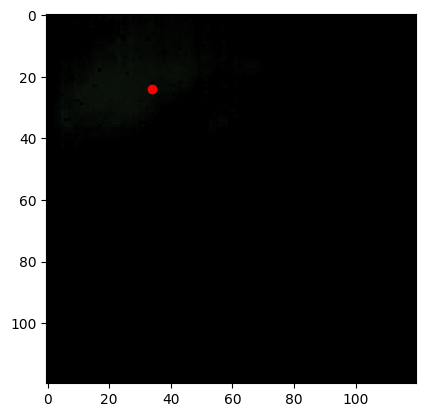

In [50]:
x.getInjectionSite('488', level = 4, plane = 'sagittal', span = 60, showPlot = True)

# is this helpful to include? 

Grabbing volumes for level: 4
Plotting coronal axis, secion: 4800 (level 4 index: 300)


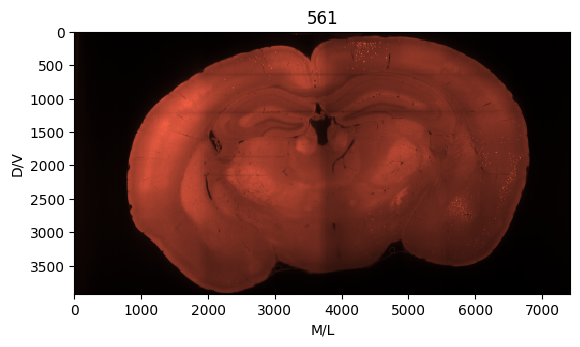

In [73]:
# need to find right section to plot 
# alternative way to plot slices in each channel, section, etc 

x.plotSlice(ch = "561", plane="coronal", level = 4, section = 4800)

In [39]:
# not sure what inputs for cst.... 
# but we probably don't need this 
x.plotPoint(cst, ch = "488",span = 20, vmin = 0, vmax = 600)


TypeError: unsupported operand type(s) for -: 'str' and 'int'

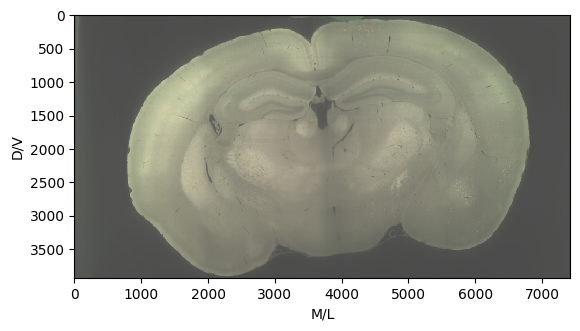

In [71]:
x.plotBlend(plane = "coronal",section = 4800, extent = [], level = 3, alphaDict = [], vDict = [], ticks = True)
# not sure if we need this... 

In [44]:
x.getNGLink()

# this could be useful if we reference the "good" ng links 

https://aind-neuroglancer-sauujisjxq-uw.a.run.app#!s3://aind-open-data/SmartSPIM_692912_2023-10-23_16-45-17_stitched_2023-10-28_20-52-28/neuroglancer_config.json


In [17]:
# Pull the cell locations transformed into CCF space using the getCellsCCF function 

cellLocs = x.getCellsCCF(["488","561"])


In [ ]:
# Generates an array of spatial coordinates (xyz) for each detected cell in the volume  

In [5]:
cellLocs["488"]

array([[  1,   1,  90],
       [  5,   1,  30],
       [  5,   1,  30],
       ...,
       [527, 319, 286],
       [527, 319, 283],
       [527, 319, 280]])

In [116]:
print(str('Number of detected cells:'), len(cellLocs["488"]))

Number of detected cells: 111606


In [ ]:
# ok now moving into CCF to create masks and find cells within particular brain regions 

In [ ]:
# actually we'll probably use this just to do the masking on the spatial locations anyways... 
# to do - find a way to use brainglobe instead of rsp to create masks 
# alternatively find notebook that references + pulls the csv's 

In [18]:
# Establish reference space
reference_space_key = 'annotation/ccf_2017'
resolution = 25
rspc = ReferenceSpaceCache(resolution, reference_space_key, manifest=Path(output_dir) / 'manifest.json')
annot, annot_info = rspc.get_annotation_volume()
structure_tree= rspc.get_structure_tree()
rsp = rspc.get_reference_space()
# Set up CCF structure lookup dicts
idMap = structure_tree.get_id_acronym_map()
acronymMap = {IDs:acronym for acronym, IDs in idMap.items()} # invert idMap

In [15]:
# from brainglobe_atlasapi import BrainGlobeAtlas
# # this takes such a long time! 
# bg_atlas = BrainGlobeAtlas("allen_mouse_100um", check_latest=False)


brainglobe_atlasapi: allen_mouse_100um not found locally. Downloading...

Output()

NameError: name 'pprint' is not defined

In [24]:
# roiList = ["MD","PT","IAD","PVT","IMD","CM","PCN","CL"]
# bg_mask = bg_atlas.get_structure_mask('MD')


In [5]:
# # create two routes here one for CCF and one using brainglobe 
# # check with mathew if everything runs correctly... 

# from brainglobe_atlasapi import BrainGlobeAtlas
# from pprint import pprint

# # bg_atlas = BrainGlobeAtlas("allen_mouse_100um", check_latest=False)

# from brainglobe_atlasapi import show_atlases
# show_atlases()

# # we want allen_mouse_10um 

╭───────────────────────────────── Brainglobe Atlases ─────────────────────────────────╮
│                                                                           Latest     │
│  Name                              Downloaded  Updated  Local version    version     │
│  example_mouse_100um                                                       1.2       │
│  allen_mouse_10um                                                          1.2       │
│  allen_mouse_25um                                                          1.2       │
│  allen_mouse_50um                                                          1.2       │
│  allen_mouse_100um                                                         1.2       │
│  mpin_zfish_1um                                                            1.0       │
│  allen_human_500um                                                         1.0       │
│  kim_mouse_10um                                                            1.1       │
│  kim_mouse_25um                                                            1.1       │
│  kim_mouse_50um                                                            1.1       │
│  kim_mouse_100um                                                           1.1       │
│  osten_mouse_10um                                                          1.1       │
│  osten_mouse_25um                                                          1.1       │
│  osten_mouse_50um                                                          1.1       │
│  osten_mouse_100um                                                         1.1       │
│  allen_cord_20um                                                           1.1       │
│  azba_zfish_4um                                                            1.2       │
│  whs_sd_rat_39um                                                           1.2       │
│  perens_lsfm_mouse_20um                                                    1.2       │
│  admba_3d_e11_5_mouse_16um                                                 1.1       │
│  admba_3d_e13_5_mouse_16um                                                 1.1       │
│  admba_3d_e15_5_mouse_16um                                                 1.1       │
│  admba_3d_e18_5_mouse_16um                                                 1.1       │
│  admba_3d_p4_mouse_16.752um                                                1.1       │
│  admba_3d_p14_mouse_16.752um                                               1.1       │
│  admba_3d_p28_mouse_16.752um                                               1.1       │
│  admba_3d_p56_mouse_25um                                                   1.1       │
│  princeton_mouse_20um                                                      1.1       │
│  kim_dev_mouse_stp_10um                                                    1.2       │
│  kim_dev_mouse_idisco_10um                                                 1.2       │
│  kim_dev_mouse_mri_a0_10um                                                 1.2       │
│  kim_dev_mouse_mri_adc_10um                                                1.2       │
│  kim_dev_mouse_mri_dwi_10um                                                1.2       │
│  kim_dev_mouse_mri_fa_10um                                                 1.2       │
│  kim_dev_mouse_mri_mtr_10um                                                1.2       │
│  kim_dev_mouse_mri_t2_10um                                                 1.2       │
│  sju_cavefish_2um                                                          1.0       │
│  allen_mouse_bluebrain_barrels_1…                                          1.0       │
│  allen_mouse_bluebrain_barrels_2…                                          1.0       │
│  unam_axolotl_40um                                                         1.0       │
│  oldenburg_blackcap_25um                                                   0.1       │
╰───────────────────────────────────────────────────────────────────────────────────

In [6]:
# Create mask of requested subset of CCF structures
# this creates an array of 0s and 1s, masking out the 3D structures you pass by name 
roiList = ["MD","PT","IAD","PVT","IMD","CM","PCN","CL"]
roiMap = structure_tree.get_id_acronym_map()
idList = [roiMap[roi] for roi in roiList]
roiMask = rsp.make_structure_mask(idList).astype('bool') # in shape AP, DV, ML
roiMask[:,:,0:220] = False # Ignore left hemisphere (half width of ML axis is 228, can revisit exact cutoff)

In [ ]:
# i'm not sure what the roiMask is doing... the shape, etc 
# need to look into the functions for reference space cache 

In [7]:
## Figure out how to find cells within CCF structure.
locCells = cellLocs["561"]
# Check if cell index is within mask of requested ROIs
cellInMask = np.zeros(len(locCells),dtype = 'bool')
for i, pos in enumerate(locCells):
    cellInMask[i] = roiMask[pos[0],pos[1],pos[2]]
    
# for every cell, check if it is within the masked brain regions, if not we don't care about it (?) 

In [77]:
len(cellInMask)

188114

In [78]:
len(locCells)

188114

In [8]:
#now this truncates everything to just the cells within the regions of interest 

maskCells = locCells[cellInMask]
uniqVals, valCounts = np.unique(annot[maskCells[:,0],maskCells[:,1],maskCells[:,2]], return_counts=True)
for count, name in enumerate(uniqVals):
    print(str(acronymMap[name]) + " " + str(valCounts[count]))
    
    # how is this assigning the cells in each mask to the correct brain region? 

PT 6
IMD 28
PVT 99
MD 411
CL 278
CM 210
PCN 457
IAD 104


In [9]:
# Sort each cell into CCF structures
uniqVals, valCounts = np.unique(annot[maskCells[:,0],maskCells[:,1],maskCells[:,2]], return_counts=True)
cellCCF = annot[maskCells[:,0],maskCells[:,1],maskCells[:,2]]
structDict = {}
for name in uniqVals:
    isStruct = cellCCF == name
    structDict[acronymMap[name]] = isStruct

In [103]:
maskCells[val,0]*25

array([6325, 6150, 6225, 6225, 6075, 6325, 6150, 6250, 6350, 6350, 6175,
       6350, 6250, 6325, 6375, 6175, 6050, 6350, 6250, 6150, 6350, 6150,
       5850, 5850, 5825, 5825, 5825, 5800, 5800, 5800, 5825, 5825, 5800,
       5800, 5775, 6150, 6150, 6025, 6000, 6175, 6075, 6125, 6050, 6150,
       6025, 6125, 6025, 6275, 6275, 6200, 6200, 6000, 6150, 6300, 6250,
       6325, 6125, 6150, 6175, 5950, 6200, 6250, 6150, 6250, 6050, 6175,
       6125, 6200, 6275, 6000, 6075, 6100, 6150, 6075, 5975, 6125, 6250,
       6325, 6075, 6250, 5975, 6000, 6325, 6350, 6200, 6300, 6350, 6075,
       6275, 6300, 5925, 6300, 6200, 6250, 6300, 6400, 6175, 6200, 6300,
       6050, 6125, 6200, 6250, 6275, 5925, 6100, 6150, 6050, 6175, 6325,
       6350, 6025, 5900, 5950, 6175, 6150, 6175, 6300, 6300, 6025, 6050,
       6175, 6375, 6075, 6075, 6325, 5950, 6100, 6400, 6125, 6150, 6350,
       6375, 6075, 6300, 6175, 6175, 6175, 6000, 6050, 6075, 6225, 6150,
       6175, 6350, 5975, 6050, 6200, 6100, 6350, 60

In [ ]:
# I think structdict is called by the brain region area 
# and then there's an array that's the size of the number of cells in the entire brain (constricted to the brain region mask) 
# that says this cell is in this region TRUE or not FALSE 

In [121]:
type(structDict["PT"])

numpy.ndarray

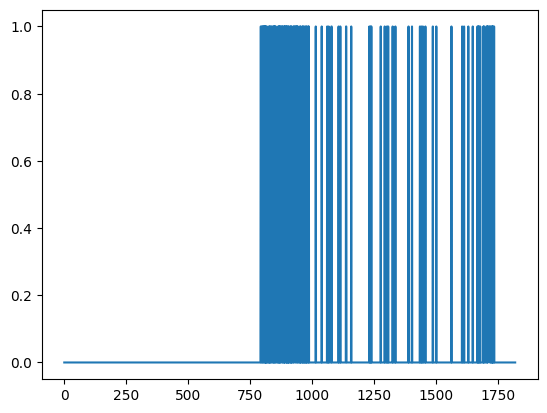

In [115]:
plt.plot(structDict["PT"])

In [117]:
len(maskCells)

1819

In [120]:
len(structDict["PT"])

1819

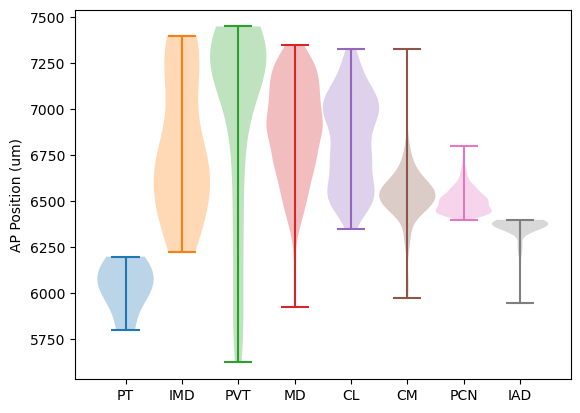

In [10]:
# why is this multiplied by 25? 
# why plot the a-p axis only? what are the other coordinates representative of?
# need some viz for representing data coordinates relative to axes dv, ap, etc 

plt.figure()
a = 1
b = []
c = []
for key, val in structDict.items():
    plt.violinplot(maskCells[val,0]*25, positions=[a], widths = 1)
    b.extend([a])
    c.extend([key])
    a = a + 1
plt.ylabel("AP Position (um)")
plt.xticks(b,c);

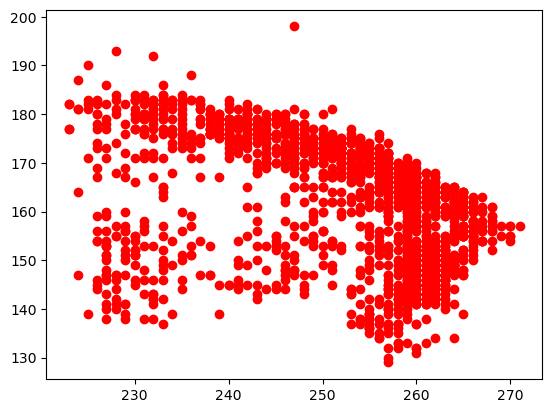

In [11]:
plt.plot(maskCells[:,2],maskCells[:,1],'or')

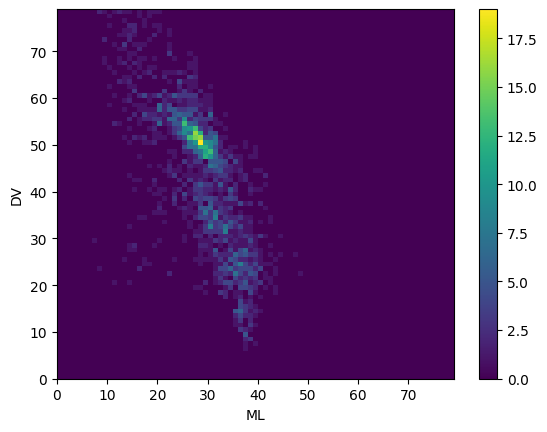

In [133]:
bin_egdes = np.arange(0,80,1)
plt.hist2d(maskCells[:,2]-220, maskCells[:,1]-120, bin_egdes)
plt.colorbar()
plt.ylabel("DV")
plt.xlabel("ML");

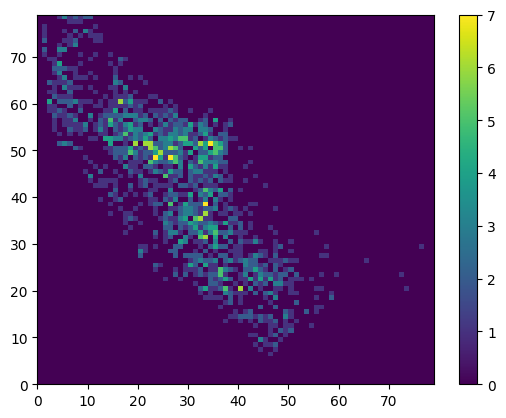

In [134]:
bin_egdes = np.arange(0,80,1)
plt.hist2d(maskCells[:,0]-220, maskCells[:,1]-120, bin_egdes)
plt.colorbar();

In [12]:
plt.ecdf(maskCells[structDict["PVT"],0]*25, label = "PVT")
plt.ecdf(maskCells[structDict["MD"],0]*25, label = "MD")
plt.ecdf(maskCells[structDict["PCN"],0]*25, label = "PCN")
plt.legend()

AttributeError: module 'matplotlib.pyplot' has no attribute 'ecdf'

In [136]:
# can we reference the metadata here or create a csv for download? 

ccfCoordDict = {685903: {'445': [171, 66, 284], '488': [162, 61, 248], '561': [157, 80, 267]},
                698035: {'445': [115, 120, 287], '488': [100, 127, 236], '561': [133, 133, 232]},
                689238: {'445': [126, 92, 259], '488': [127, 84, 271], '561': [122, 138, 237]},
                691387: {'445': [94, 117, 279], '488': [103, 124, 295], '561': [103, 131, 314]},
                691388: {'445': [107, 126, 259], '488': [99, 130, 274], '561': [102, 112, 238]},
                694512: {'445': [142, 101, 237], '488': [154, 75, 254], '561': [157, 89, 238]},
                695721: {'445': [107, 98, 255], '488': [144, 85, 258], '561': [129, 89, 254]},
                696668: {'561': [161, 82, 241]},
                684812: {'445': [166, 65, 197], '488': [166, 70, 265], '561': [167, 85, 240]},
                684821: {'488': [119, 100, 266], '561': [121, 98, 298]},
                689237: {'445': [139, 96, 244], '561': [140, 86, 295]},
                696669: {'445': [141, 87, 289], '561': [105, 113, 287]},
                693977: {'488': [154, 93, 268], '561': [93, 139, 240]},
                698927: {'488': [104, 128, 295], '561': [95, 117, 245]},
                698928: {'488': [146, 138, 232], '561': [145, 88, 271]},
                693979: {'488': [164, 91, 239], '561': [154, 95, 264]},
                693980: {'488': [120, 139, 293], '561': [115, 101, 286]},
                692909: {'561': [122, 132, 294]},
                692907: {'561': [115, 112, 244]},
                692912: {'561': [152, 131, 245]},
                692911: {'561': [123, 127, 294]},
                701750: {'561': [150, 142, 243]},
                701751: {'561': [105, 126, 284]},
                701754: {'561': [146, 80, 255]},
                721832: {'488': [120, 145, 306]}} #manually annotated, estimate injection site later

virusDict = {685903:'AAVrg-XFP',
             # 698034:'AAVrg',
             698035:'AAVrg-XFP',
             689238:'AAVrg-XFP',
             691387:'AAVrg-XFP',
             691388:'AAVrg-XFP',
             694512:'AAVrg-XFP',
             695721:'AAVrg-XFP',
             696668:'AAVrg-XFP',
             684812:'AAVrg-XFP',
             684821:'AAVrg-XFP',
             689237:'AAVrg-XFP',
             696669:'AAVrg-XFP',
             693977:"RabV-XFP",
             698927:"RabV-XFP",
             698928:"RabV-XFP",
             693979:"RabV-XFP",
             693980:"RabV-XFP",
             692909:"AAVrg-Recombinase",
             692907:"AAVrg-Recombinase",
             692912:"AAVrg-Recombinase",
             692911:"AAVrg-Recombinase",
             685110:"AAVrg-Recombinase",
             701750:"RabV-Recombinase",
             701751:"RabV-Recombinase",
             701754:"RabV-Recombinase",
             721832:"AAVrg-XFP"
            }

In [ ]:
# now this is moving to the population level stuff 

In [137]:
# Create mask of requested subset of CCF structures
roiList = ["MD","PT","IAD","PVT","IMD","CM","PCN","CL"]
roiMap = structure_tree.get_id_acronym_map()
idList = [roiMap[roi] for roi in roiList]
roiMask = rsp.make_structure_mask(idList).astype('bool') # in shape AP, DV, ML
roiMask[:,:,0:220] = False # Ignore left hemisphere (half width of ML axis is 228, can revisit exact cutoff)

In [130]:
# still don't fully understand how the roiMask works.... 

array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, Fal

In [138]:
cellDict = {}
for sample in ccfCoordDict.keys():
    brainObj = brain(sample, level=3)
    chList = list(brainObj.ccfCellsPaths.keys())
    cellLocs = brainObj.getCellsCCF(chList)
    for channel in ccfCoordDict[sample].keys():
        cells = cellLocs[channel]
        cellInMask = np.zeros(len(cells),dtype = 'bool')
        for i, pos in enumerate(cells):
            cellInMask[i] = roiMask[pos[0],pos[1],pos[2]]
        cellDict[str(sample) + " " + channel] = cells[cellInMask]

# brainLists = [691387, 691388, 694512, 698035, 689238]
# chList = ["445","488","561"]
# cellDict = {}
# for sample in brainLists:
#     brainObj = brain(sample)
#     cellLocs = brainObj.getCellsCCF(chList)
#     for channel in chList:
#         cells = cellLocs[channel]
#         cellInMask = np.zeros(len(cells),dtype = 'bool')
#         for i, pos in enumerate(cells):
#             cellInMask[i] = roiMask[pos[0],pos[1],pos[2]]
#         cellDict[str(sample) + " " + channel] = cells[cellInMask]

Loading data from ../data/SmartSPIM_685903_2023-08-23_13-03-18_stitched_2023-11-07_22-40-00/image_tile_fusing/OMEZarr
Found the following channels: ['445', '488', '561', '639']
Found cell segmentations in the following channels: ['445', '488', '561']
Found CCF aligned quantifications in the following channels: ['445', '488', '561']
Grabbing volumes for level: 3
Loading data from ../data/SmartSPIM_698035_2023-10-24_18-38-40_stitched_2023-10-28_20-52-51/image_tile_fusing/OMEZarr
Found the following channels: ['445', '488', '561', '639']
Found cell segmentations in the following channels: ['445', '488', '561']
Found CCF aligned quantifications in the following channels: ['445', '488', '561']
Grabbing volumes for level: 3
Loading data from ../data/SmartSPIM_689238_2023-08-31_01-56-52_stitched_2023-09-12_07-47-44/image_tile_fusing/OMEZarr
Found the following channels: ['445', '488', '561', '639']
Found cell segmentations in the following channels: ['445', '488', '561']
Found CCF aligned qua

Found cell segmentations in the following channels: ['488', '561']
Found CCF aligned quantifications in the following channels: ['488', '561']
Grabbing volumes for level: 3
Loading data from ../data/SmartSPIM_721832_2024-03-29_19-37-36_stitched_2024-04-05_09-23-40/image_tile_fusing/OMEZarr
Found the following channels: ['488', '561', '639']
Found cell segmentations in the following channels: ['488', '561']
Found CCF aligned quantifications in the following channels: ['488', '561']
Grabbing volumes for level: 3


In [139]:
# see how many cells are counted w/in the mask for each channel 

for key, val in cellDict.items():
    print(key + ": " + str(len(val)))

685903 445: 6
685903 488: 1530
685903 561: 1593
698035 445: 2473
698035 488: 4380
698035 561: 3915
689238 445: 1383
689238 488: 3505
689238 561: 3023
691387 445: 927
691387 488: 3562
691387 561: 1066
691388 445: 6785
691388 488: 4699
691388 561: 3656
694512 445: 1976
694512 488: 5875
694512 561: 2308
695721 445: 2884
695721 488: 5858
695721 561: 3514
696668 561: 2234
684812 445: 213
684812 488: 3405
684812 561: 1731
684821 488: 4271
684821 561: 1331
689237 445: 2322
689237 561: 1275
696669 445: 2475
696669 561: 2767
693977 488: 1027
693977 561: 1804
698927 488: 4271
698927 561: 4351
698928 488: 1438
698928 561: 351
693979 488: 787
693979 561: 1826
693980 488: 1991
693980 561: 738
692909 561: 3716
692907 561: 4879
692912 561: 1819
692911 561: 2086
701750 561: 416
701751 561: 608
701754 561: 440
721832 488: 9066


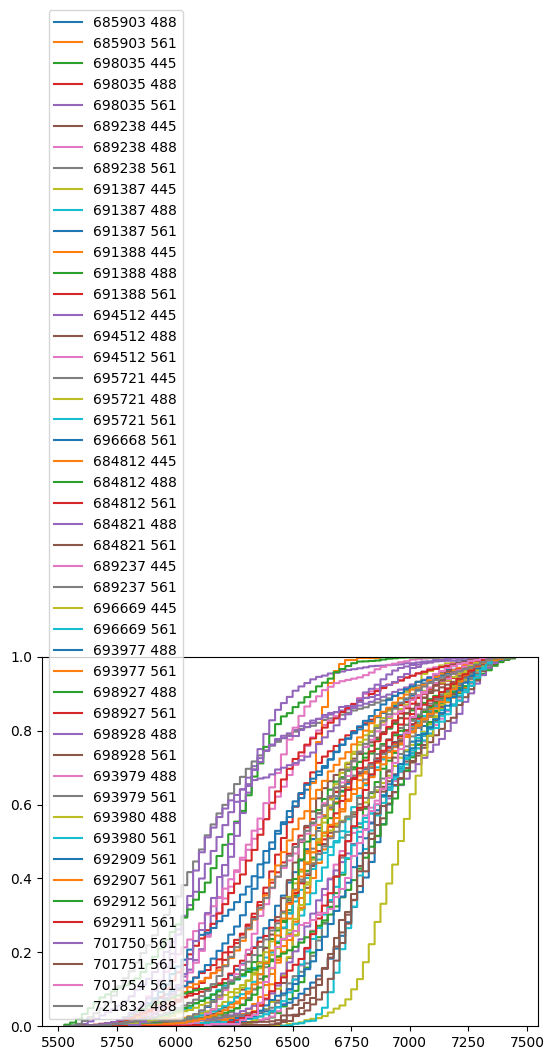

In [141]:
for key, val in cellDict.items():
    if len(val) > 100:
        plt.ecdf(val[:,0]*25, label = key)
plt.legend()

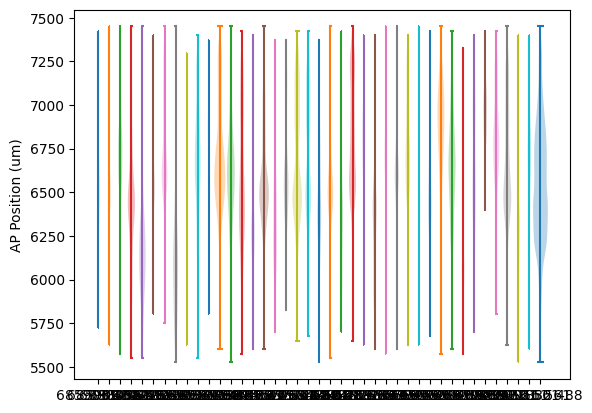

In [142]:
plt.figure()
a = 1
b = []
c = []
for key, val in cellDict.items():
    if len(val) > 800:
        plt.violinplot(val[:,0]*25, positions=[a], widths = len(val)/6785)
        b.extend([a])
        c.extend([key])
        a = a + 1
plt.ylabel("AP Position (um)")
plt.xticks(b,c);

In [143]:
#reshape the cellDict w/ the cell locations into a pandas dataframe 

pd.DataFrame.from_dict(cellDict, orient = "index")

/opt/conda/lib/python3.9/site-packages/pandas/core/internals/construction.py:568: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])


,0
685903 445,"[[248, 177, 242], [248, 177, 242], [248, 178, ..."
685903 488,"[[279, 138, 229], [263, 136, 230], [293, 142, ..."
685903 561,"[[285, 137, 233], [291, 141, 227], [290, 141, ..."
698035 445,"[[288, 135, 225], [284, 136, 233], [293, 137, ..."
698035 488,"[[288, 135, 222], [293, 138, 231], [286, 136, ..."
698035 561,"[[293, 127, 255], [292, 127, 255], [293, 127, ..."
689238 445,"[[291, 126, 257], [291, 128, 257], [294, 130, ..."
689238 488,"[[294, 131, 258], [290, 130, 256], [291, 131, ..."
689238 561,"[[236, 156, 222], [235, 157, 232], [235, 158, ..."
691387 445,"[[285, 140, 233], [282, 143, 240], [279, 145, ..."


In [145]:
cellDict["689238 561"].shape

(3023, 3)

In [146]:
np.vstack(cellDict.values())

<ipython-input-146-3362b2b3a9db>:1: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  np.vstack(cellDict.values())


array([[248, 177, 242],
       [248, 177, 242],
       [248, 178, 242],
       ...,
       [294, 175, 232],
       [295, 179, 236],
       [293, 179, 238]])

<ipython-input-147-05f476d98bba>:1: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  stackCells = np.vstack(cellDict.values())


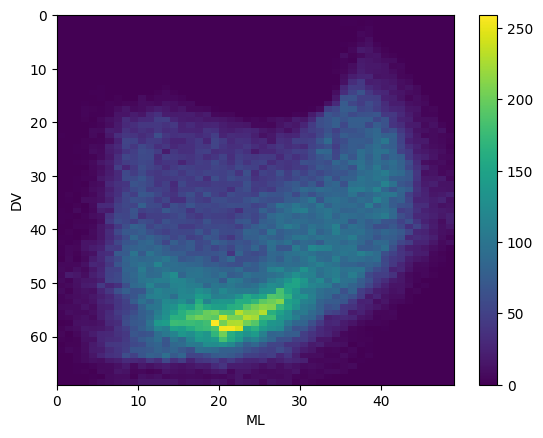

In [147]:
stackCells = np.vstack(cellDict.values())
# stackCells = np.vstack((cellDict["689238 561"],cellDict["689238 488"]))
stepSize = 1
x_bin_edges = np.arange(0,50,stepSize)
y_bin_edges = np.arange(0,70,stepSize)
plt.hist2d(stackCells[:,2]-220, stackCells[:,1]-120, (x_bin_edges, y_bin_edges))
plt.gca().invert_yaxis()
plt.colorbar()
plt.ylabel("DV")
plt.xlabel("ML")
plt.savefig("../results/coronal hist.png",dpi=300)

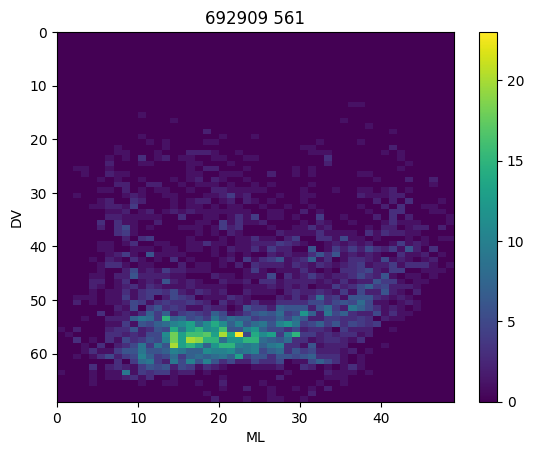

In [31]:
i = 41
expList = list(cellDict.keys())
stackCells = cellDict[expList[i]]
x_bin_edges = np.arange(0,50,stepSize)
y_bin_edges = np.arange(0,70,stepSize)
bin_egdes = np.arange(0,80,1)
plt.hist2d(stackCells[:,2]-220, stackCells[:,1]-120, (x_bin_edges, y_bin_edges))
plt.gca().invert_yaxis()
plt.colorbar()
plt.title(expList[i])
plt.ylabel("DV")
plt.xlabel("ML");
plt.savefig("../results/hist ex 3.png",dpi=300, transparent=True)

<ipython-input-32-1501a1a0c808>:1: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  stackCells = np.vstack(cellDict.values())


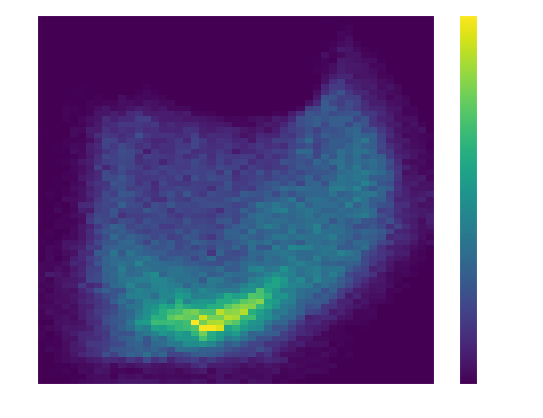

In [32]:
stackCells = np.vstack(cellDict.values())
# stackCells = np.vstack((cellDict["689238 561"],cellDict["689238 488"]))
stepSize = 1
x_bin_edges = np.arange(0,50,stepSize)
y_bin_edges = np.arange(0,70,stepSize)
plt.hist2d(stackCells[:,2]-220, stackCells[:,1]-120, (x_bin_edges, y_bin_edges), cmap = 'viridis')
plt.gca().invert_yaxis()
# Set the color of the axes to white
plt.gca().spines['bottom'].set_color('white')
plt.gca().spines['top'].set_color('white') 
plt.gca().spines['right'].set_color('white')
plt.gca().spines['left'].set_color('white')

# Set the color of the ticks to white
plt.tick_params(axis='x', colors='white')
plt.tick_params(axis='y', colors='white')

# set colorbar label plus label color
cb = plt.colorbar()
cb.set_label('Cell count', color='white')

# set colorbar tick color
cb.ax.yaxis.set_tick_params(color='white')

# set colorbar edgecolor 
cb.outline.set_edgecolor('white')

# set colorbar ticklabels
plt.setp(plt.getp(cb.ax.axes, 'yticklabels'), color='white')
plt.savefig("../results/coronal hist.png",dpi=300, transparent =True)

<ipython-input-33-d9765cba1846>:1: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  stackCells = np.vstack(cellDict.values())


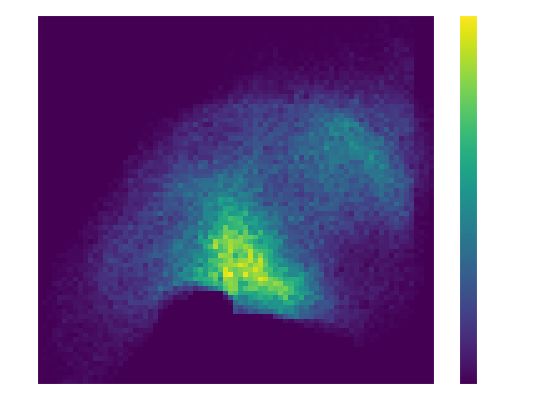

In [33]:
stackCells = np.vstack(cellDict.values())
# stackCells = np.vstack((cellDict["689238 561"],cellDict["689238 488"]))
bin_egdes = np.arange(0,80,1)
plt.hist2d(stackCells[:,0]-220, stackCells[:,1]-120, bin_egdes, cmap = "viridis")
plt.gca().invert_yaxis()

# Set the color of the axes to white
plt.gca().spines['bottom'].set_color('white')
plt.gca().spines['top'].set_color('white') 
plt.gca().spines['right'].set_color('white')
plt.gca().spines['left'].set_color('white')

# Set the color of the ticks to white
plt.tick_params(axis='x', colors='white')
plt.tick_params(axis='y', colors='white')

# set colorbar label plus label color
cb = plt.colorbar()
cb.set_label('Cell count', color='white')

# set colorbar tick color
cb.ax.yaxis.set_tick_params(color='white')

# set colorbar edgecolor 
cb.outline.set_edgecolor('white')

# set colorbar ticklabels
plt.setp(plt.getp(cb.ax.axes, 'yticklabels'), color='white')

plt.savefig("../results/sagittal hist.png",dpi=300, transparent=True)

<ipython-input-34-2763f4d1bb22>:15: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout();


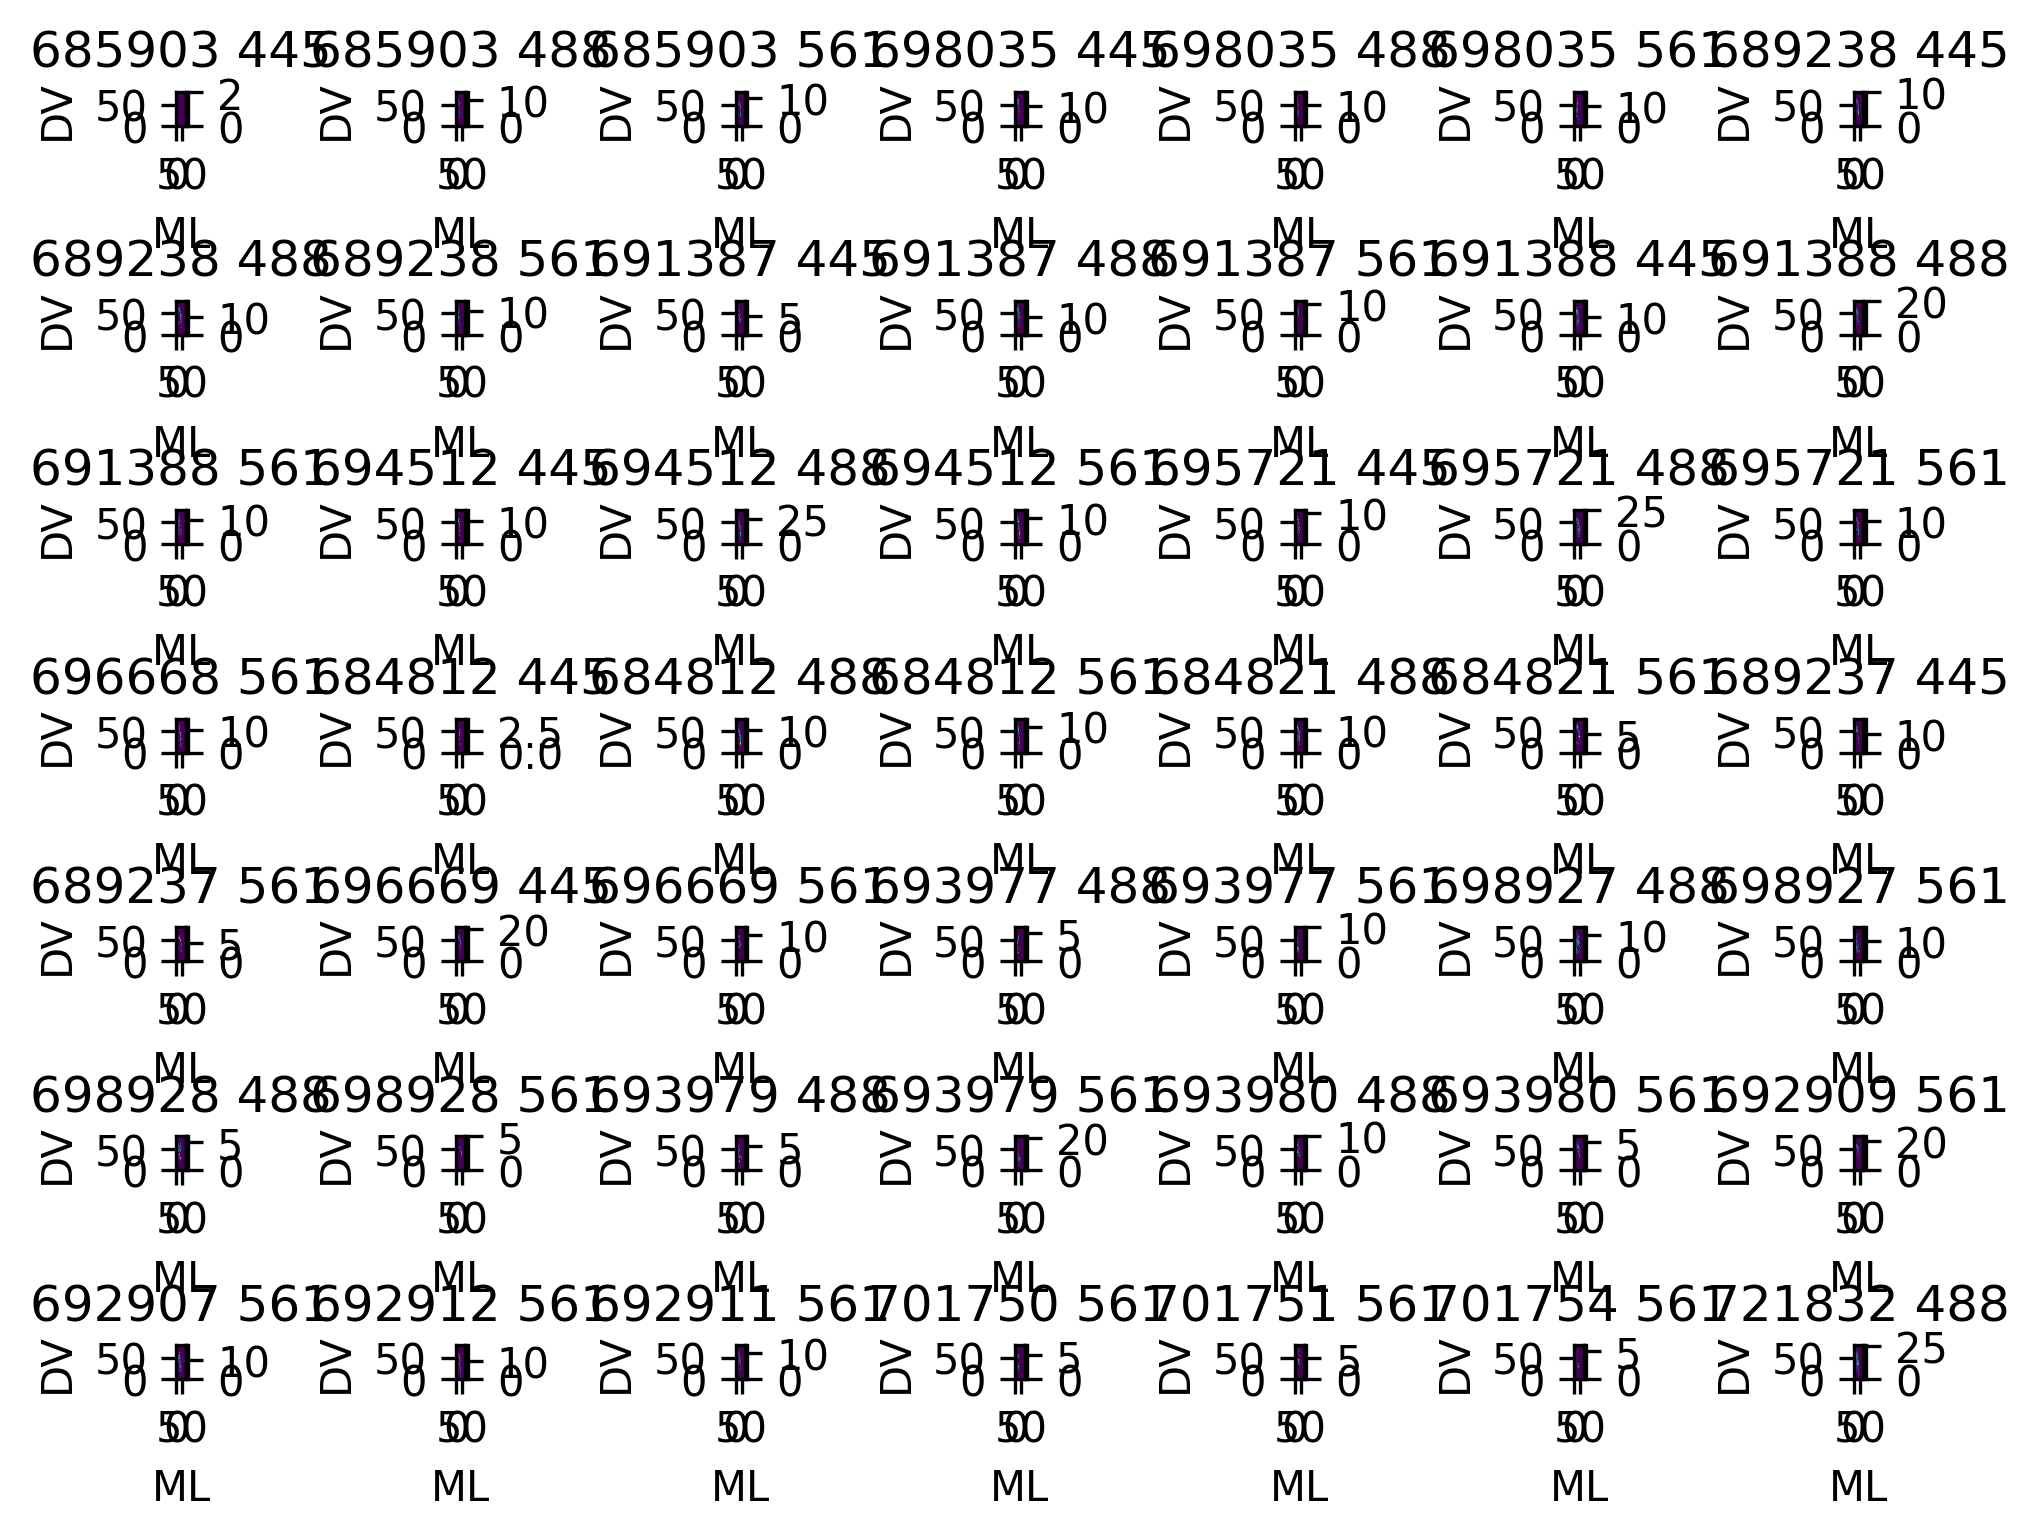

In [34]:
plt.figure(dpi=300)
bin_egdes = np.arange(0,80,1)
nExps = len(cellDict)
nRow = int(np.floor(np.sqrt(nExps)))
nCol = int(np.ceil(nExps / nRow))
for i, items in enumerate(cellDict.items(), 1):
    key, val = items
    plt.subplot(nRow,nCol,i)
    plt.hist2d(val[:,2]-220, val[:,1]-120, bin_egdes)
    plt.colorbar()
    plt.title(key)
    plt.ylabel("DV")
    plt.xlabel("ML")
    # plt.rc('font',**{"size": 3})
    plt.tight_layout();

## Try NMF

In [35]:
from sklearn.decomposition import NMF

In [36]:
## Prepare data as an array of dictionaries
expList = list(cellDict.keys())
nExps = len(expList)
stepSize = 1
x_bin_edges = np.arange(0,50,stepSize)
y_bin_edges = np.arange(0,70,stepSize)
xLen = len(x_bin_edges)-1
yLen = len(y_bin_edges)-1
vectorSize = xLen*yLen # convert 2d array to vector
histArray = np.empty((nExps,vectorSize))
for i in range(nExps):
    stackCells = cellDict[expList[i]]
    a, xa, ya = np.histogram2d(stackCells[:,2]-220, stackCells[:,1]-120, (x_bin_edges, y_bin_edges)) # Coronal section
    # a, xa, ya = np.histogram2d(stackCells[:,0]-220, stackCells[:,1]-120, (x_bin_edges, y_bin_edges)) # Sagittal section
    histArray[i,:] = a.reshape(1,vectorSize)
# plt.imshow(a.T, origin='lower')

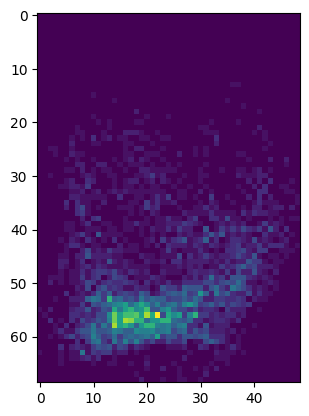

In [37]:
i = 41
# plt.imshow(histArray[i,:].reshape((xLen,yLen)).T, origin = "lower")
plt.imshow(histArray[i,:].reshape((xLen,yLen)).T)

In [38]:
model = NMF(n_components=5, init='random', random_state=0)
W = model.fit_transform(histArray)
H = model.components_

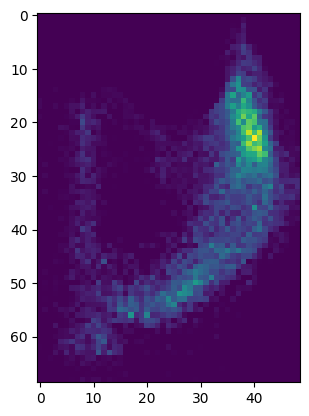

In [39]:
i = 0
# plt.imshow(H[i,:].reshape((xLen,yLen)).T, origin = "lower")
plt.imshow(H[i,:].reshape((xLen,yLen)).T)

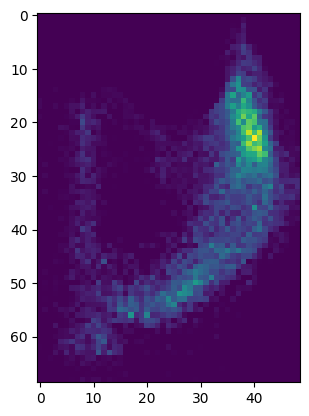

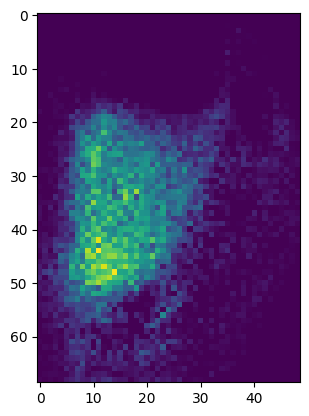

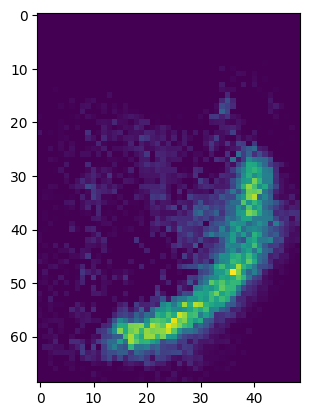

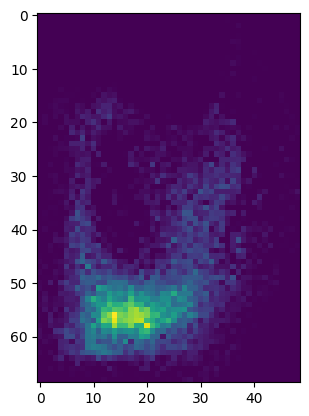

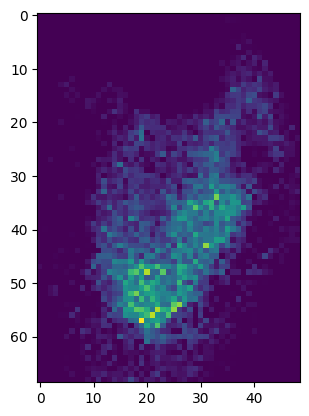

In [40]:
for i in range(5):
    plt.figure()
    # plt.imshow(H[i,:].reshape((xLen,yLen)).T, origin = "lower")
    plt.imshow(H[i,:].reshape((xLen,yLen)).T)
    fn = "../results/component " + str(i) + ".svg"
    plt.savefig(fn,dpi=300)

In [41]:
vars(model)

{'n_components': 5,
 'init': 'random',
 'beta_loss': 'frobenius',
 'tol': 0.0001,
 'max_iter': 200,
 'random_state': 0,
 'alpha_W': 0.0,
 'alpha_H': 'same',
 'l1_ratio': 0.0,
 'verbose': 0,
 'solver': 'cd',
 'shuffle': False,
 'n_features_in_': 3381,
 '_n_components': 5,
 '_beta_loss': 2,
 'reconstruction_err_': 419.71290055165315,
 'n_components_': 5,
 'components_': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 'n_iter_': 109}

In [42]:
W.shape

(49, 5)

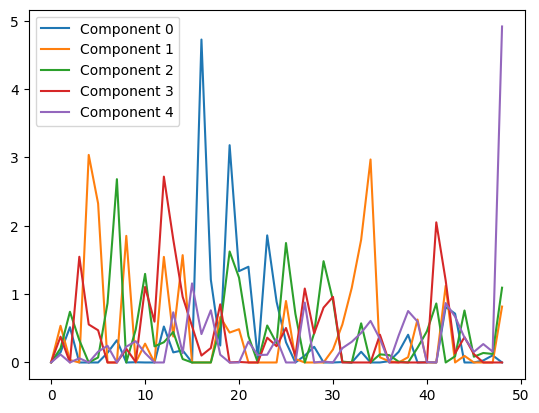

In [43]:
plt.figure()
for i in range(W.shape[1]):
    label = "Component " + str(i)
    plt.plot(W[:,i],label=label)
plt.legend()

In [44]:
wHeldOut = W
# wHeldOut[12,:] = 0
np.argmax(W[:,0])
list(cellDict.keys())[16]

'694512 488'

In [45]:
np.argmax(W[:,4])
list(cellDict.keys())[48]

'721832 488'

In [46]:
maxComponents = 20
modelErr = np.zeros(maxComponents-1)
norm = np.linalg.norm(histArray)
for i in range(1,maxComponents):
    model = NMF(n_components=i, init='random', random_state=0)
    W = model.fit_transform(histArray)
#     H = model.components_
    modelErr[i-1] = model.reconstruction_err_

/opt/conda/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1770: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1770: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1770: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1770: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1770: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/dec

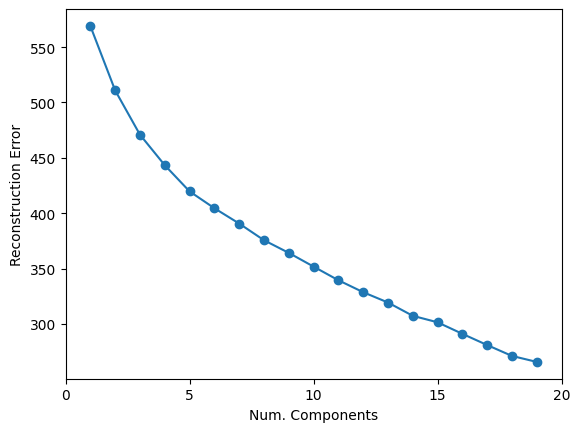

In [47]:
plt.plot(np.arange(1,20),modelErr,'o-')
plt.xticks(np.arange(0,21,5))
plt.ylabel("Reconstruction Error")
plt.xlabel("Num. Components")
plt.savefig("../results/NMF Reconstruction Error.svg",dpi=300)

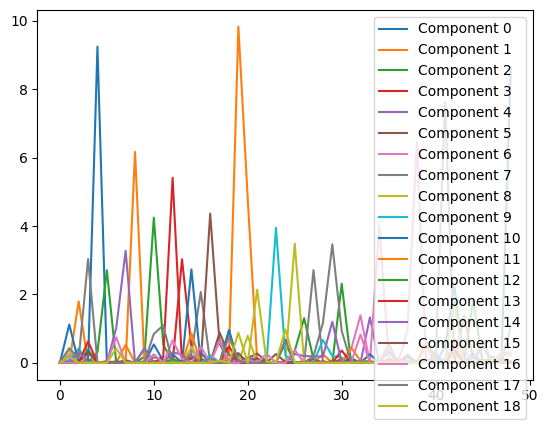

In [48]:
plt.figure()
for i in range(W.shape[1]):
    label = "Component " + str(i)
    plt.plot(W[:,i],label=label)
plt.legend()

## Construct dataframe for further analysis of NMF domains

In [49]:
nComponents = 5
model = NMF(n_components=nComponents, init='random', random_state=0)
W = model.fit_transform(histArray)
H = model.components_

In [50]:
sampleList = []
chList = []
for count, name in enumerate(expList):
    sampleList.append(np.int64(expList[count][0:6]))
    chList.append(expList[count][7:])
chList = np.array(chList)

In [51]:
# Format dataframe
ccfData = pd.DataFrame(ccfCoordDict).transpose()
ccfData.insert(0,"Sample",ccfData.index)
ccfData = ccfData.melt(id_vars="Sample", var_name = "Channel", value_name="CCF Coord")
ccfData = ccfData.dropna(axis = 0, how = "any")
# Re-establish index
ccfData.index = ccfData.Sample
ccfData = ccfData.drop(columns = "Sample")

# Add virus dictionary
ccfData.insert(2,"Virus",np.nan)
ccfData.insert(3,"Payload",np.nan)
ccfData.insert(4,"Capsid",np.nan)
for sample, virus in virusDict.items():
    ccfData.loc[sample,["Virus","Payload","Capsid"]] = [virus, virus.split('-')[1], virus.split('-')[0]]

# Get coordinates for projection
ccfCoords = np.array(list(ccfData["CCF Coord"]))

# Get CCF Structure
ccfData.insert(5,"CCF Struct",np.nan)
ccfData.insert(6,"CCF Parent",np.nan)
coordMap = structure_tree.get_structures_by_id(annot[ccfCoords[:,0],ccfCoords[:,1],ccfCoords[:,2]])
for count, structDict in enumerate(coordMap):
    ccfData["CCF Struct"].iloc[count] = structDict["acronym"]
    ccfData["CCF Parent"].iloc[count] = acronymMap[structDict["structure_id_path"][-2]] # get next level parent acronym
    
# Add factor contribution. ccfData order is different from expList due to melt operation.
# Trying to reconcile these here - may be more complicated than need be...
nExps = len(sampleList)
expIndx = np.empty(nExps, dtype = int)
for count, sample in enumerate(zip(ccfData.index, ccfData.Channel)):
    for i in range(nExps):
        if (sample[0] == sampleList[i]) & (sample[1] == chList[i]):
            expIndx[count] = i
            break

for i in range(nComponents):
    field = "Factor " + str(i)
    ccfData[field] = W[expIndx,i] / np.max(W[expIndx,i])

<ipython-input-51-84a085dabbb2>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ccfData["CCF Struct"].iloc[count] = structDict["acronym"]
<ipython-input-51-84a085dabbb2>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ccfData["CCF Parent"].iloc[count] = acronymMap[structDict["structure_id_path"][-2]] # get next level parent acronym


In [52]:
W[expIndx,0]

array([0.00000000e+00, 0.00000000e+00, 1.41055174e-01, 3.33641737e-03,
       5.25888731e-01, 0.00000000e+00, 2.48218089e-01, 6.02010663e-02,
       1.00418583e-01, 0.00000000e+00, 1.47436355e-01, 0.00000000e+00,
       3.25364474e-01, 0.00000000e+00, 1.47670783e-01, 4.72471675e+00,
       3.17911845e+00, 1.85940929e+00, 2.96072247e-01, 5.72780882e-03,
       1.56564392e-01, 0.00000000e+00, 1.56130581e-01, 0.00000000e+00,
       0.00000000e+00, 5.15912453e-01, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 1.77805401e-01, 1.21076970e+00, 1.33615353e+00,
       1.40040885e+00, 8.87917373e-01, 0.00000000e+00, 2.29391931e-01,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.93846649e-02,
       4.05854057e-01, 4.55313946e-03, 0.00000000e+00, 8.11162689e-01,
       7.14775326e-01, 0.00000000e+00, 0.00000000e+00, 2.95539822e-02,
       1.04171268e-01])

In [53]:
nExps = len(sampleList)
expIndx = np.empty(nExps, dtype = int)
for count, sample in enumerate(zip(ccfData.index, ccfData.Channel)):
    for i in range(nExps):
        if (sample[0] == sampleList[i]) & (sample[1] == chList[i]):
            expIndx[count] = i
            break
            # print(str(sampleList[i]) + ' ' + chList[i] + ' ' + str(i))
    # print(sample[1])

In [54]:
expIndx

array([ 0,  3,  6,  9, 12, 15, 18, 22, 27, 29,  1,  4,  7, 10, 13, 16, 19,
       23, 25, 31, 33, 35, 37, 39, 48,  2,  5,  8, 11, 14, 17, 20, 21, 24,
       26, 28, 30, 32, 34, 36, 38, 40, 41, 42, 43, 44, 45, 46, 47])

In [55]:
ccfData.head(5)

,Channel,CCF Coord,Virus,Payload,Capsid,CCF Struct,CCF Parent,Factor 0,Factor 1,Factor 2,Factor 3,Factor 4
Sample,,,,,,,,,,,,
685903,445,"[171, 66, 284]",AAVrg-XFP,XFP,AAVrg,MOs2/3,MOs,0.000000,0.000000,0.001529,0.002336,0.000284
698035,445,"[115, 120, 287]",AAVrg-XFP,XFP,AAVrg,FRP6a,FRP,0.000000,0.000000,0.121842,0.568858,0.012629
689238,445,"[126, 92, 259]",AAVrg-XFP,XFP,AAVrg,MOs5,MOs,0.029855,0.000000,0.322743,0.000000,0.049789
691387,445,"[94, 117, 279]",AAVrg-XFP,XFP,AAVrg,FRP5,FRP,0.000706,0.000000,0.178841,0.002770,0.063426
691388,445,"[107, 126, 259]",AAVrg-XFP,XFP,AAVrg,ORBvl5,ORBvl,0.111306,0.508699,0.110327,1.000000,0.000000


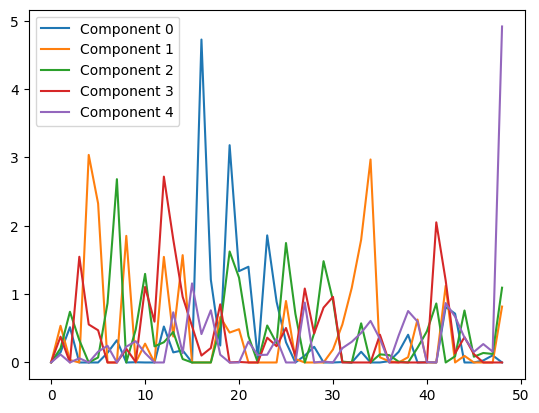

In [56]:
plt.figure()
for i in range(W.shape[1]):
    label = "Component " + str(i)
    plt.plot(W[:,i],label=label)
plt.legend()

In [57]:
ccfData.head(5)

,Channel,CCF Coord,Virus,Payload,Capsid,CCF Struct,CCF Parent,Factor 0,Factor 1,Factor 2,Factor 3,Factor 4
Sample,,,,,,,,,,,,
685903,445,"[171, 66, 284]",AAVrg-XFP,XFP,AAVrg,MOs2/3,MOs,0.000000,0.000000,0.001529,0.002336,0.000284
698035,445,"[115, 120, 287]",AAVrg-XFP,XFP,AAVrg,FRP6a,FRP,0.000000,0.000000,0.121842,0.568858,0.012629
689238,445,"[126, 92, 259]",AAVrg-XFP,XFP,AAVrg,MOs5,MOs,0.029855,0.000000,0.322743,0.000000,0.049789
691387,445,"[94, 117, 279]",AAVrg-XFP,XFP,AAVrg,FRP5,FRP,0.000706,0.000000,0.178841,0.002770,0.063426
691388,445,"[107, 126, 259]",AAVrg-XFP,XFP,AAVrg,ORBvl5,ORBvl,0.111306,0.508699,0.110327,1.000000,0.000000


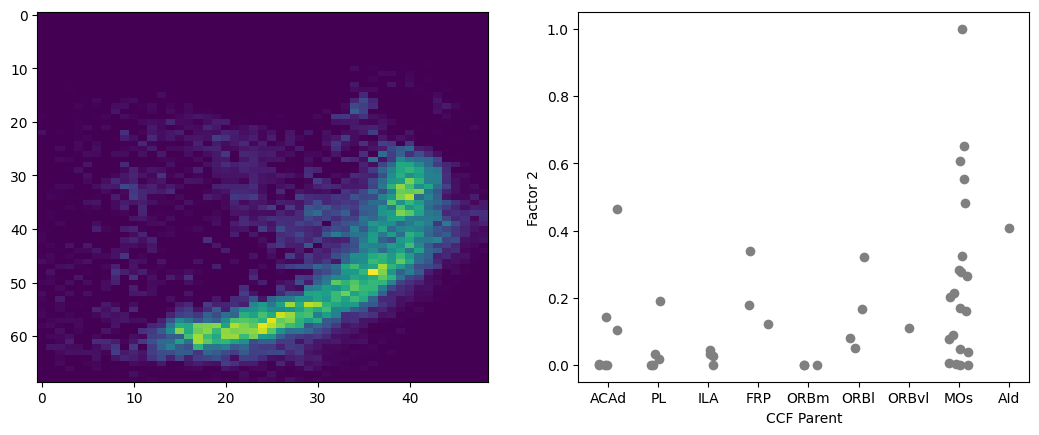

In [58]:
i = 2
plt.figure(figsize = (12.8,4.8)) # size of 2 figures
plt.subplot(1,2,1)
plt.imshow(H[i,:].reshape((xLen,yLen)).T, cmap = "viridis")
plt.axis('tight')
plt.subplot(1,2,2)
field = "Factor " + str(i)
sns.stripplot(ccfData,x = "CCF Parent", y = field, color = "gray", order=["ACAd","PL","ILA","FRP","ORBm","ORBl","ORBvl","MOs","AId"], s = 7, jitter = .2)
# sns.despine()
plt.axis('tight');

## Try to add flatmap representations

In [59]:
from pathlib import Path
from allensdk.core.reference_space_cache import ReferenceSpaceCache
import ccf_streamlines.projection as ccfproj
output_dir = '../scratch/'
# Establish reference space
reference_space_key = 'annotation/ccf_2017'
resolution = 25
rspc = ReferenceSpaceCache(resolution, reference_space_key, manifest=Path(output_dir) / 'manifest.json')
annot, annot_info = rspc.get_annotation_volume()
structure_tree= rspc.get_structure_tree()
rsp = rspc.get_reference_space()
# Set up CCF structure lookup dicts
idMap = structure_tree.get_id_acronym_map()
acronymMap = {IDs:acronym for acronym, IDs in idMap.items()} # invert idMap

In [61]:
from allensdk.api import api
apiObj = api.Api("../results")
apiObj.retrieve_file_over_http("http://download.alleninstitute.org/informatics-archive/current-release/mouse_ccf/cortical_coordinates/ccf_2017/ccf_streamlines_assets/view_lookup/flatmap_dorsal.h5","../scratch/flatmap_dorsal.h5")
apiObj.retrieve_file_over_http("http://download.alleninstitute.org/informatics-archive/current-release/mouse_ccf/cortical_coordinates/ccf_2017/ccf_streamlines_assets/master_updated/labelDescription_ITKSNAPColor.txt","../scratch/labelDescription_ITKSNAPColor.txt")
apiObj.retrieve_file_over_http("http://download.alleninstitute.org/informatics-archive/current-release/mouse_ccf/cortical_coordinates/ccf_2017/ccf_streamlines_assets/streamlines/closest_surface_voxel_lookup.h5","../scratch/closest_surface_voxel_lookup.h5")
apiObj.retrieve_file_over_http("http://download.alleninstitute.org/informatics-archive/current-release/mouse_ccf/cortical_coordinates/ccf_2017/ccf_streamlines_assets/master_updated/flatmap_dorsal.nrrd","../scratch/flatmap_dorsal.nrrd")
apiObj.retrieve_file_over_http("http://download.alleninstitute.org/informatics-archive/current-release/mouse_ccf/cortical_coordinates/ccf_2017/ccf_streamlines_assets/streamlines/surface_paths_10_v3.h5","../scratch/surface_paths_10_v3.h5")

2024-10-14 22:43:24,684 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://download.alleninstitute.org/informatics-archive/current-release/mouse_ccf/cortical_coordinates/ccf_2017/ccf_streamlines_assets/view_lookup/flatmap_dorsal.h5
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://download.alleninstitute.org/informatics-archive/current-release/mouse_ccf/cortical_coordinates/ccf_2017/ccf_streamlines_assets/view_lookup/flatmap_dorsal.h5
2024-10-14 22:43:25,114 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://download.alleninstitute.org/informatics-archive/current-release/mouse_ccf/cortical_coordinates/ccf_2017/ccf_streamlines_assets/master_updated/labelDescription_ITKSNAPColor.txt
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://download.alleninstitute.org/informatics-archive/current-release/mouse_ccf/cortical_coordinates/ccf_2017/ccf_streamlines_assets/master_updated/labelDescription_ITKSNAPColor.tx

In [62]:
# Get flatmap boundaries
bf_boundary_finder = ccfproj.BoundaryFinder(
    projected_atlas_file="../scratch/flatmap_dorsal.nrrd",
    labels_file="../scratch/labelDescription_ITKSNAPColor.txt",
)

# And we can get the right hemisphere boundaries that match up with
# our projection if we specify the same configuration
bf_right_boundaries = bf_boundary_finder.region_boundaries(
    # we want the right hemisphere boundaries, but located in the right place
    # to plot both hemispheres at the same time
    hemisphere='right',

    # we also want the hemispheres to be adjacent
    view_space_for_other_hemisphere='flatmap_dorsal',
)

# Setup projector object
ccf_coord_proj = ccfproj.IsocortexCoordinateProjector(
    projection_file="../scratch/flatmap_dorsal.h5",
    surface_paths_file="../scratch/surface_paths_10_v3.h5",
    closest_surface_voxel_reference_file="../scratch/closest_surface_voxel_lookup.h5"
)

In [63]:
# Project CCF coords onto flatmap
injCoords = ccfCoords*25 # convert from voxels to microns

# Project injection site onto dorsal flatmap
projCoords = ccf_coord_proj.project_coordinates(injCoords, scale='voxels', hemisphere = 'right', view_space_for_other_hemisphere="flatmap_dorsal")

# Add projections to dataframe
ccfData.insert(4,"ML",np.nan)
ccfData.insert(5,"AP",np.nan)
ccfData.insert(6,"DV",np.nan)
ccfData.loc[:,["ML","AP","DV"]] = projCoords

loading path information


100%|██████████| 1/1 [00:00<00:00, 11.08it/s]


loading path information


100%|██████████| 1/1 [00:00<00:00, 13.83it/s]


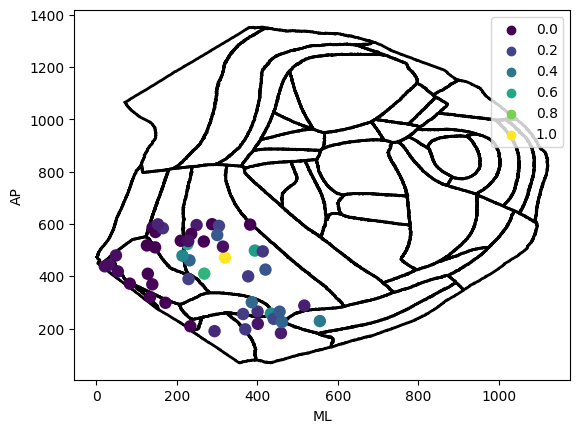

In [64]:
for k, boundary_coords in bf_right_boundaries.items():
    plt.plot(*boundary_coords.T, color = 'k', lw= 2)

sns.scatterplot(ccfData,x = "ML", y = "AP",edgecolor = "none", hue = "Factor 2",zorder = 2, s =80, palette = "viridis")
plt.legend(loc = "upper right")

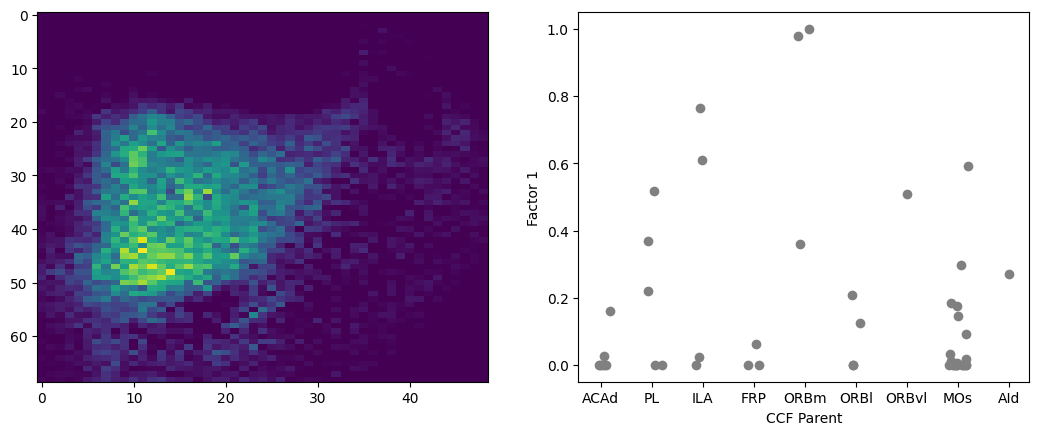

In [65]:
i = 1
plt.figure(figsize = (12.8,4.8)) # size of 2 figures
plt.subplot(1,2,1)
plt.imshow(H[i,:].reshape((xLen,yLen)).T, cmap = "viridis")
plt.axis('tight')
plt.subplot(1,2,2)
field = "Factor " + str(i)
sns.stripplot(ccfData,x = "CCF Parent", y = field, color = "gray", order=["ACAd","PL","ILA","FRP","ORBm","ORBl","ORBvl","MOs","AId"], s = 7, jitter = .2)
# sns.despine()
plt.axis('tight');

In [67]:
ccfData.sort_values("Factor 1", ascending=False)

,Channel,CCF Coord,Virus,Payload,ML,AP,DV,Capsid,CCF Struct,CCF Parent,Factor 0,Factor 1,Factor 2,Factor 3,Factor 4
Sample,,,,,,,,,,,,,,,
698035,488,"[100, 127, 236]",AAVrg-XFP,XFP,133.618581,320.676997,21.571068,AAVrg,ORBm2/3,ORBm,0.000000,1.000000,0.000000,0.204636,0.000000
698927,561,"[95, 117, 245]",RabV-XFP,XFP,171.660765,298.509909,51.351032,RabV,ORBm5,ORBm,0.000000,0.977963,0.000000,0.000000,0.123709
698035,561,"[133, 133, 232]",AAVrg-XFP,XFP,53.381823,418.263842,9.500000,AAVrg,ILA1,ILA,0.000000,0.765712,0.027195,0.173286,0.032192
689238,561,"[122, 138, 237]",AAVrg-XFP,XFP,83.157766,371.701000,22.596194,AAVrg,ILA5,ILA,0.000000,0.610028,0.000000,0.073956,0.046986
698927,488,"[104, 128, 295]",RabV-XFP,XFP,440.482395,237.094796,68.187895,RabV,MOs5,MOs,0.033137,0.591277,0.213579,0.000000,0.088075
691388,561,"[102, 112, 238]",AAVrg-XFP,XFP,139.000000,369.000000,26.985281,AAVrg,PL5,PL,0.037633,0.517145,0.018765,0.353641,0.027692
691388,445,"[107, 126, 259]",AAVrg-XFP,XFP,293.611876,190.022012,73.344202,AAVrg,ORBvl5,ORBvl,0.111306,0.508699,0.110327,1.000000,0.000000
692907,561,"[115, 112, 244]",AAVrg-Recombinase,Recombinase,127.834377,409.396486,44.642136,AAVrg,PL5,PL,0.171685,0.369479,0.000000,0.440712,0.176837
693977,561,"[93, 139, 240]",RabV-XFP,XFP,233.450909,208.685830,29.894912,RabV,ORBm2/3,ORBm,0.000000,0.359436,0.000000,0.000000,0.061482


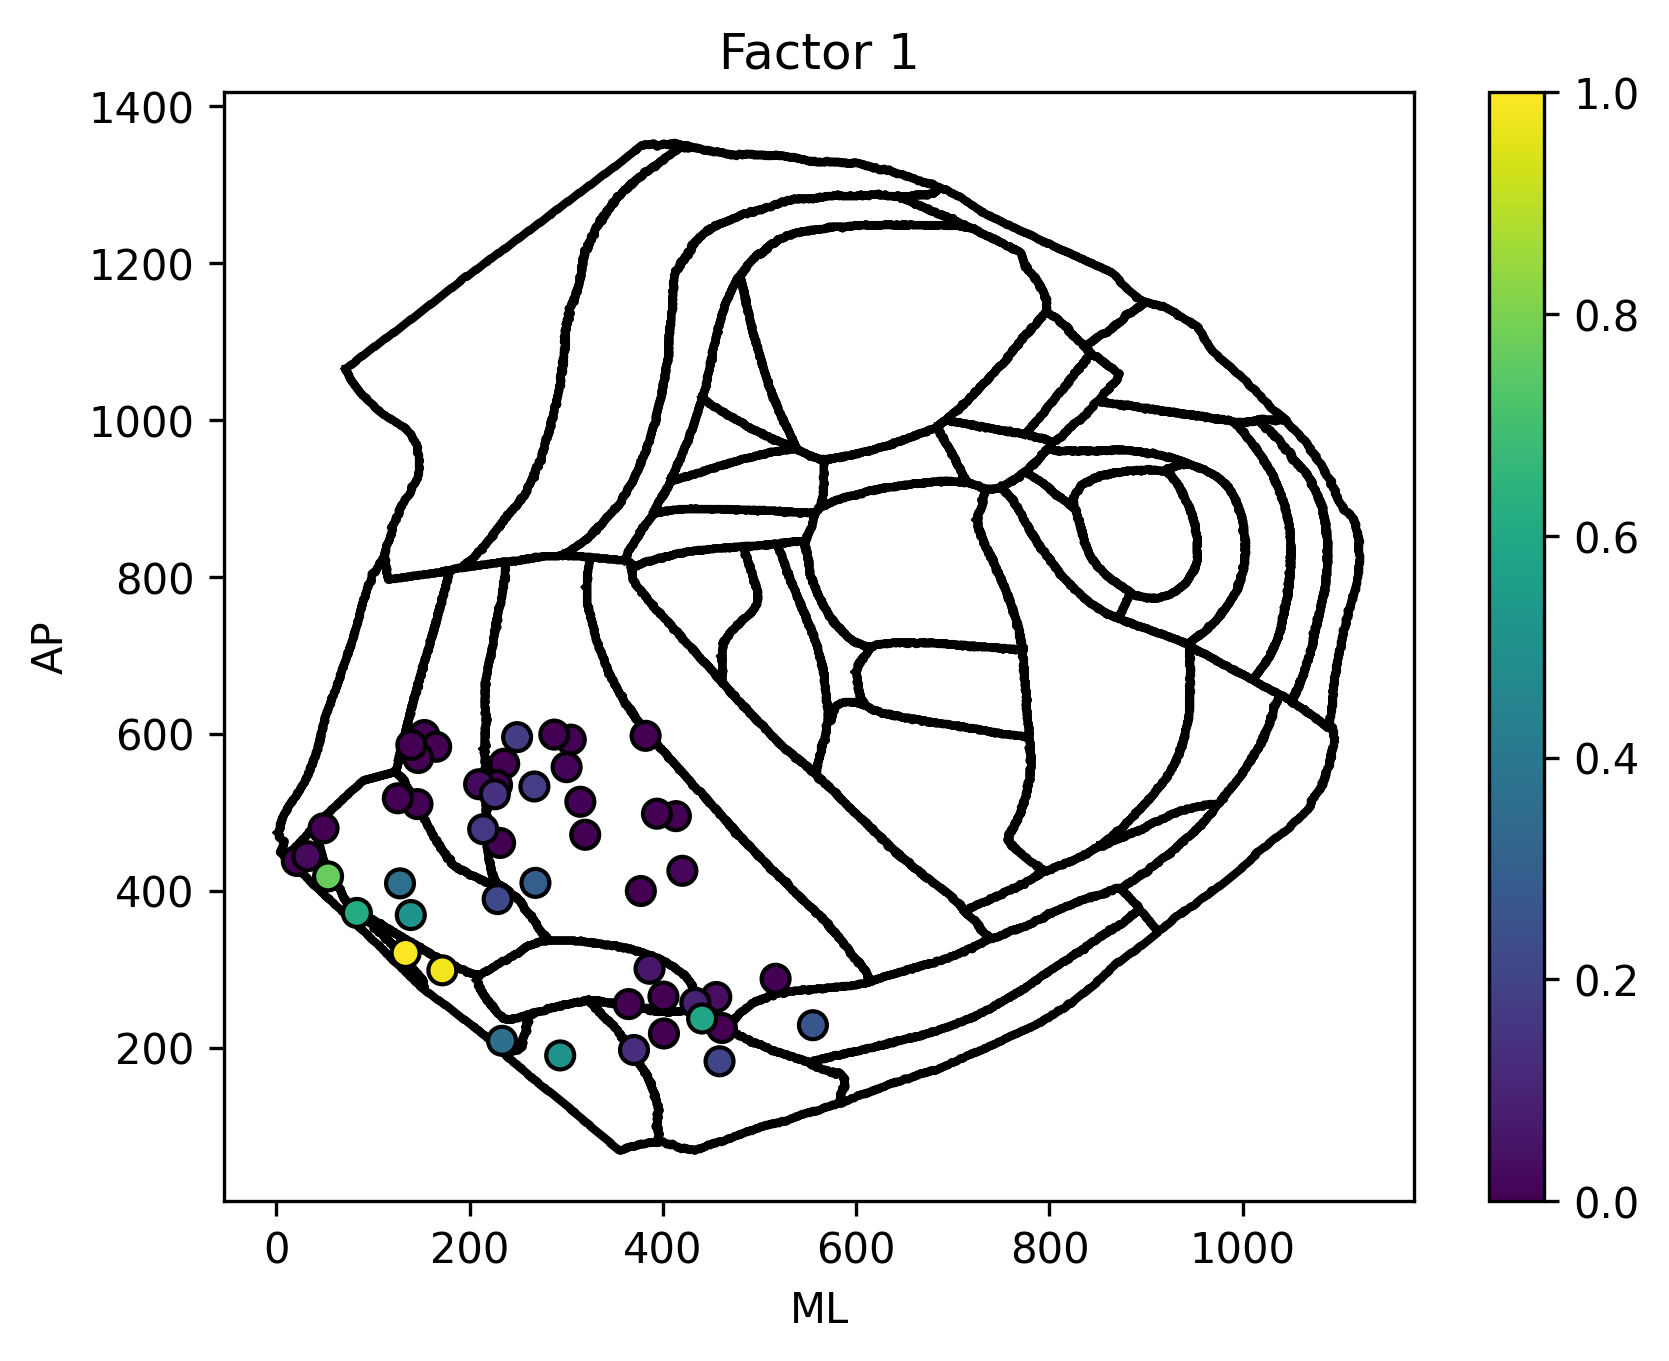

In [68]:
struct = "Factor 1"
plotData = ccfData.copy()
plt.figure(dpi=300)
for k, boundary_coords in bf_right_boundaries.items():
    plt.plot(*boundary_coords.T, color = 'k', lw= 2)

plotData = plotData.sort_values(by=struct,ascending=True) # sort for plotting largest value on top
ax = sns.scatterplot(plotData,x = "ML", y = "AP", s = 45, hue = struct, hue_norm=(0,1),
                     edgecolor = 'black', linewidth = 1, zorder = 2, palette = 'viridis')

norm = plt.Normalize(0, 1)
sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
sm = plt.cm.ScalarMappable(cmap="viridis")
plt.colorbar(sm, ax = ax)
ax.get_legend().remove()
plt.title(struct)
plt.savefig("../results/factor 1 flatmap.svg",dpi=300)

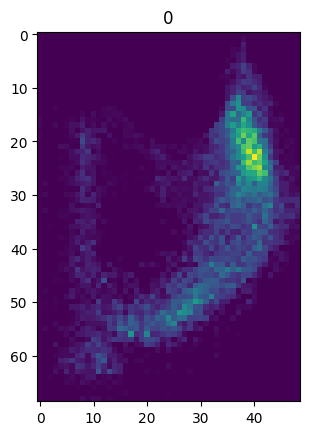

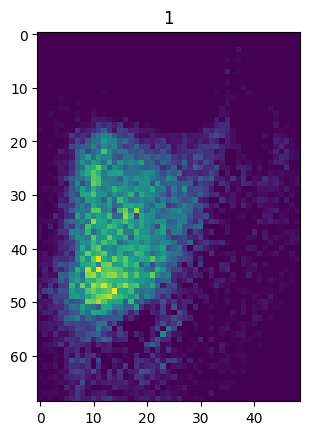

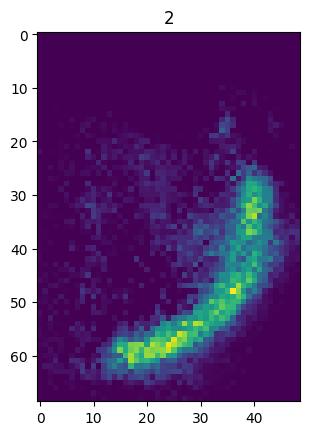

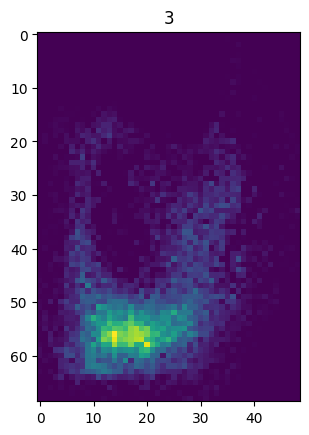

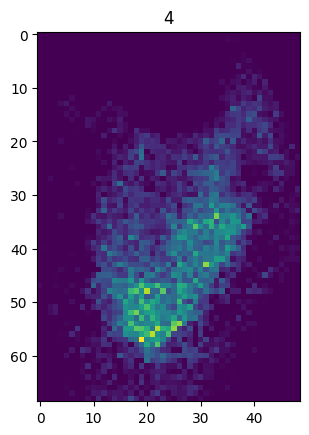

In [69]:
for i in range(5):
    plt.figure()
    # plt.imshow(H[i,:].reshape((xLen,yLen)).T, origin = "lower")
    plt.imshow(H[i,:].reshape((xLen,yLen)).T)
    plt.title(i)

In [70]:
from matplotlib.colors import Normalize, to_hex

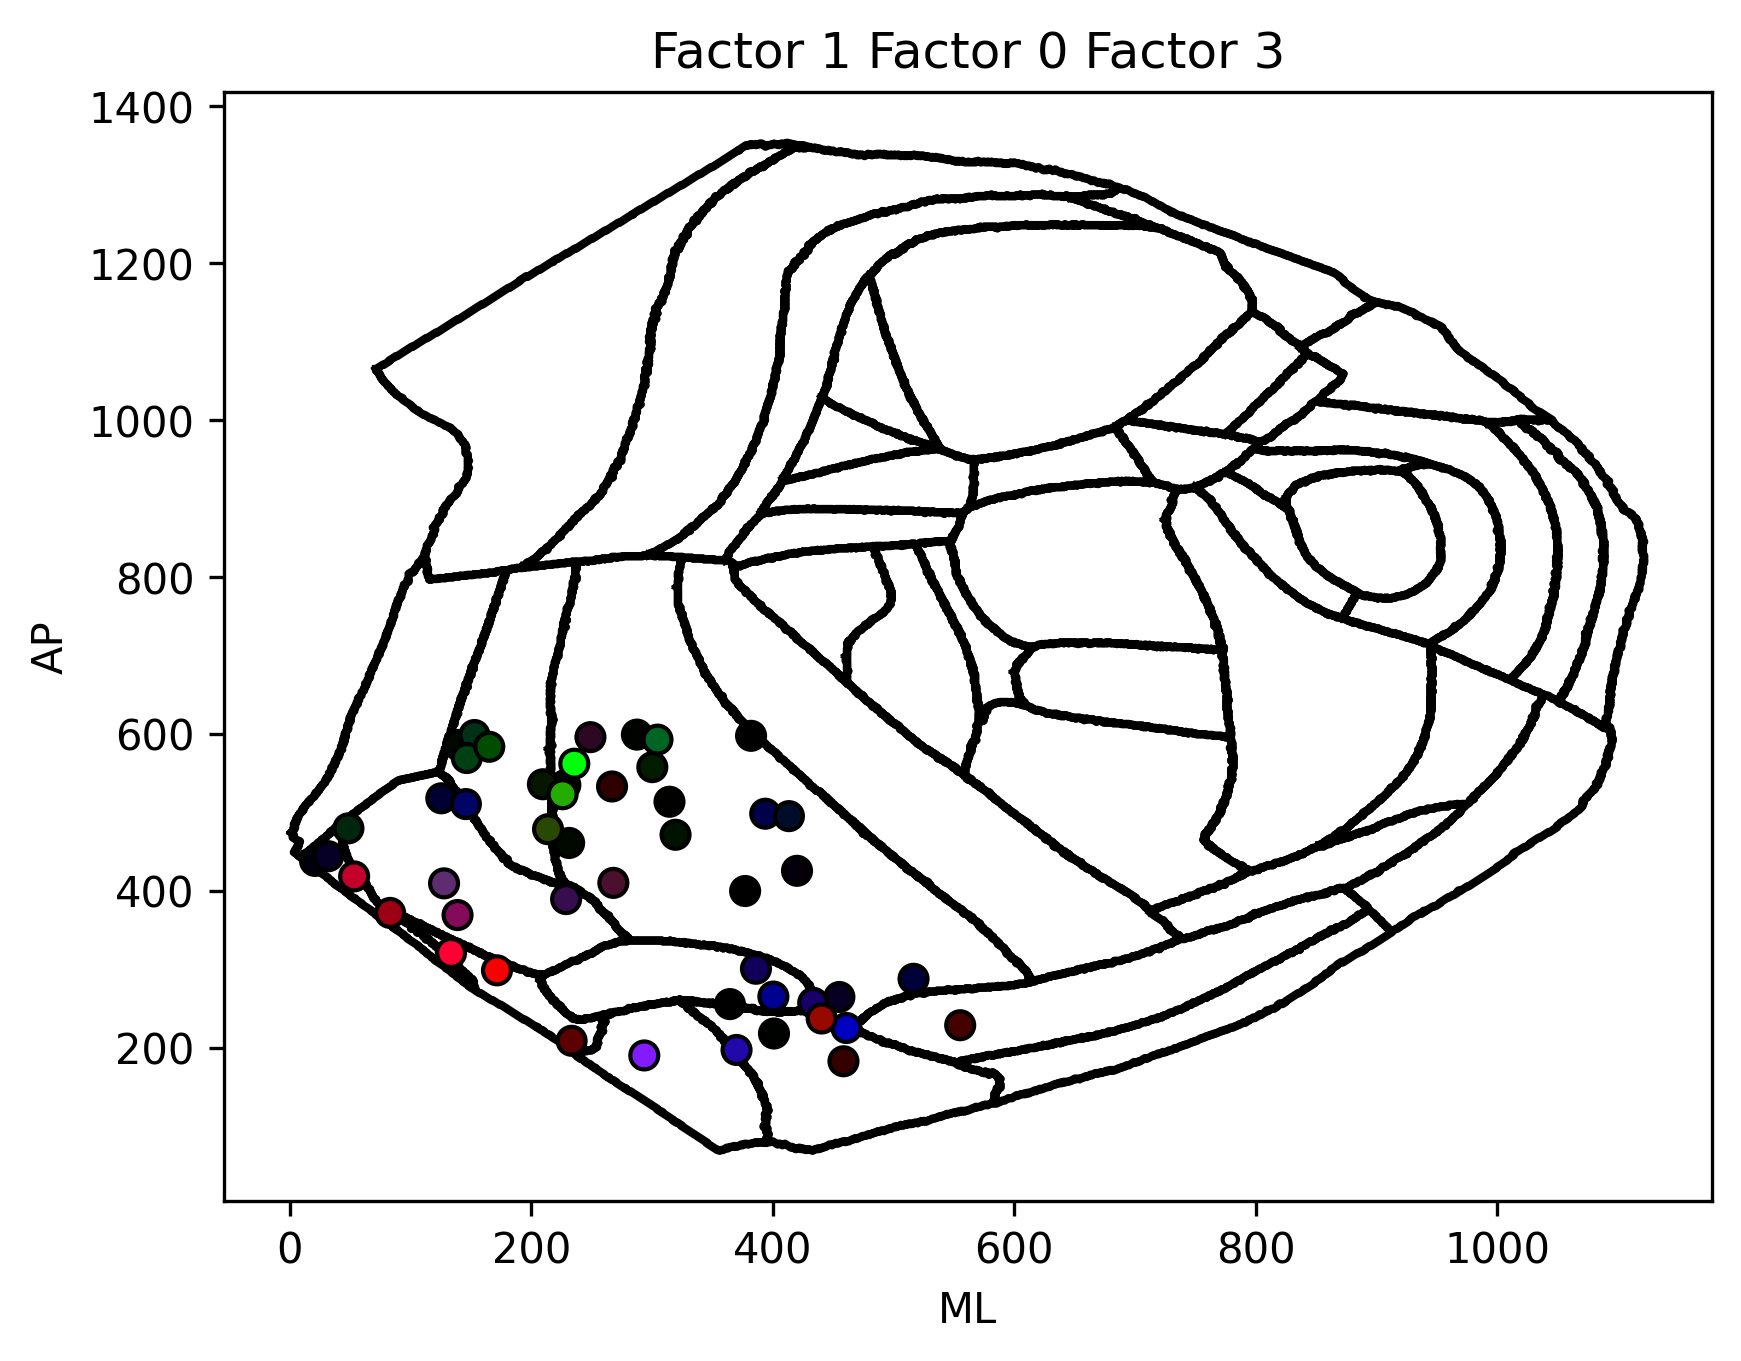

In [71]:

# rFactor = "Factor 0"
# gFactor = "Factor 1"
# bFactor = "Factor 2"

rFactor = "Factor 1"
gFactor = "Factor 0"
bFactor = "Factor 3"
plotData = ccfData.copy()
plt.figure(dpi=300)
for k, boundary_coords in bf_right_boundaries.items():
    plt.plot(*boundary_coords.T, color = 'k', lw= 2)

plotData['color'] = plotData.apply(lambda row: to_hex((row[rFactor], row[gFactor], row[bFactor])), axis=1)
palette = {color: color for color in plotData['color'].unique()}
plotData = plotData.sort_values(by='color',ascending=True) # sort for plotting largest value on top
ax = sns.scatterplot(plotData,x = "ML", y = "AP", s = 45, hue = "color",
                     edgecolor = 'black', linewidth = 1, zorder = 2, palette = palette)

ax.get_legend().remove()
plt.title(rFactor + " " + gFactor + " " + bFactor)
plt.savefig("../results/joint factors flatmap.svg",dpi=300)

Text(0.5, 1.0, 'Factor 1 Factor 0 Factor 2')

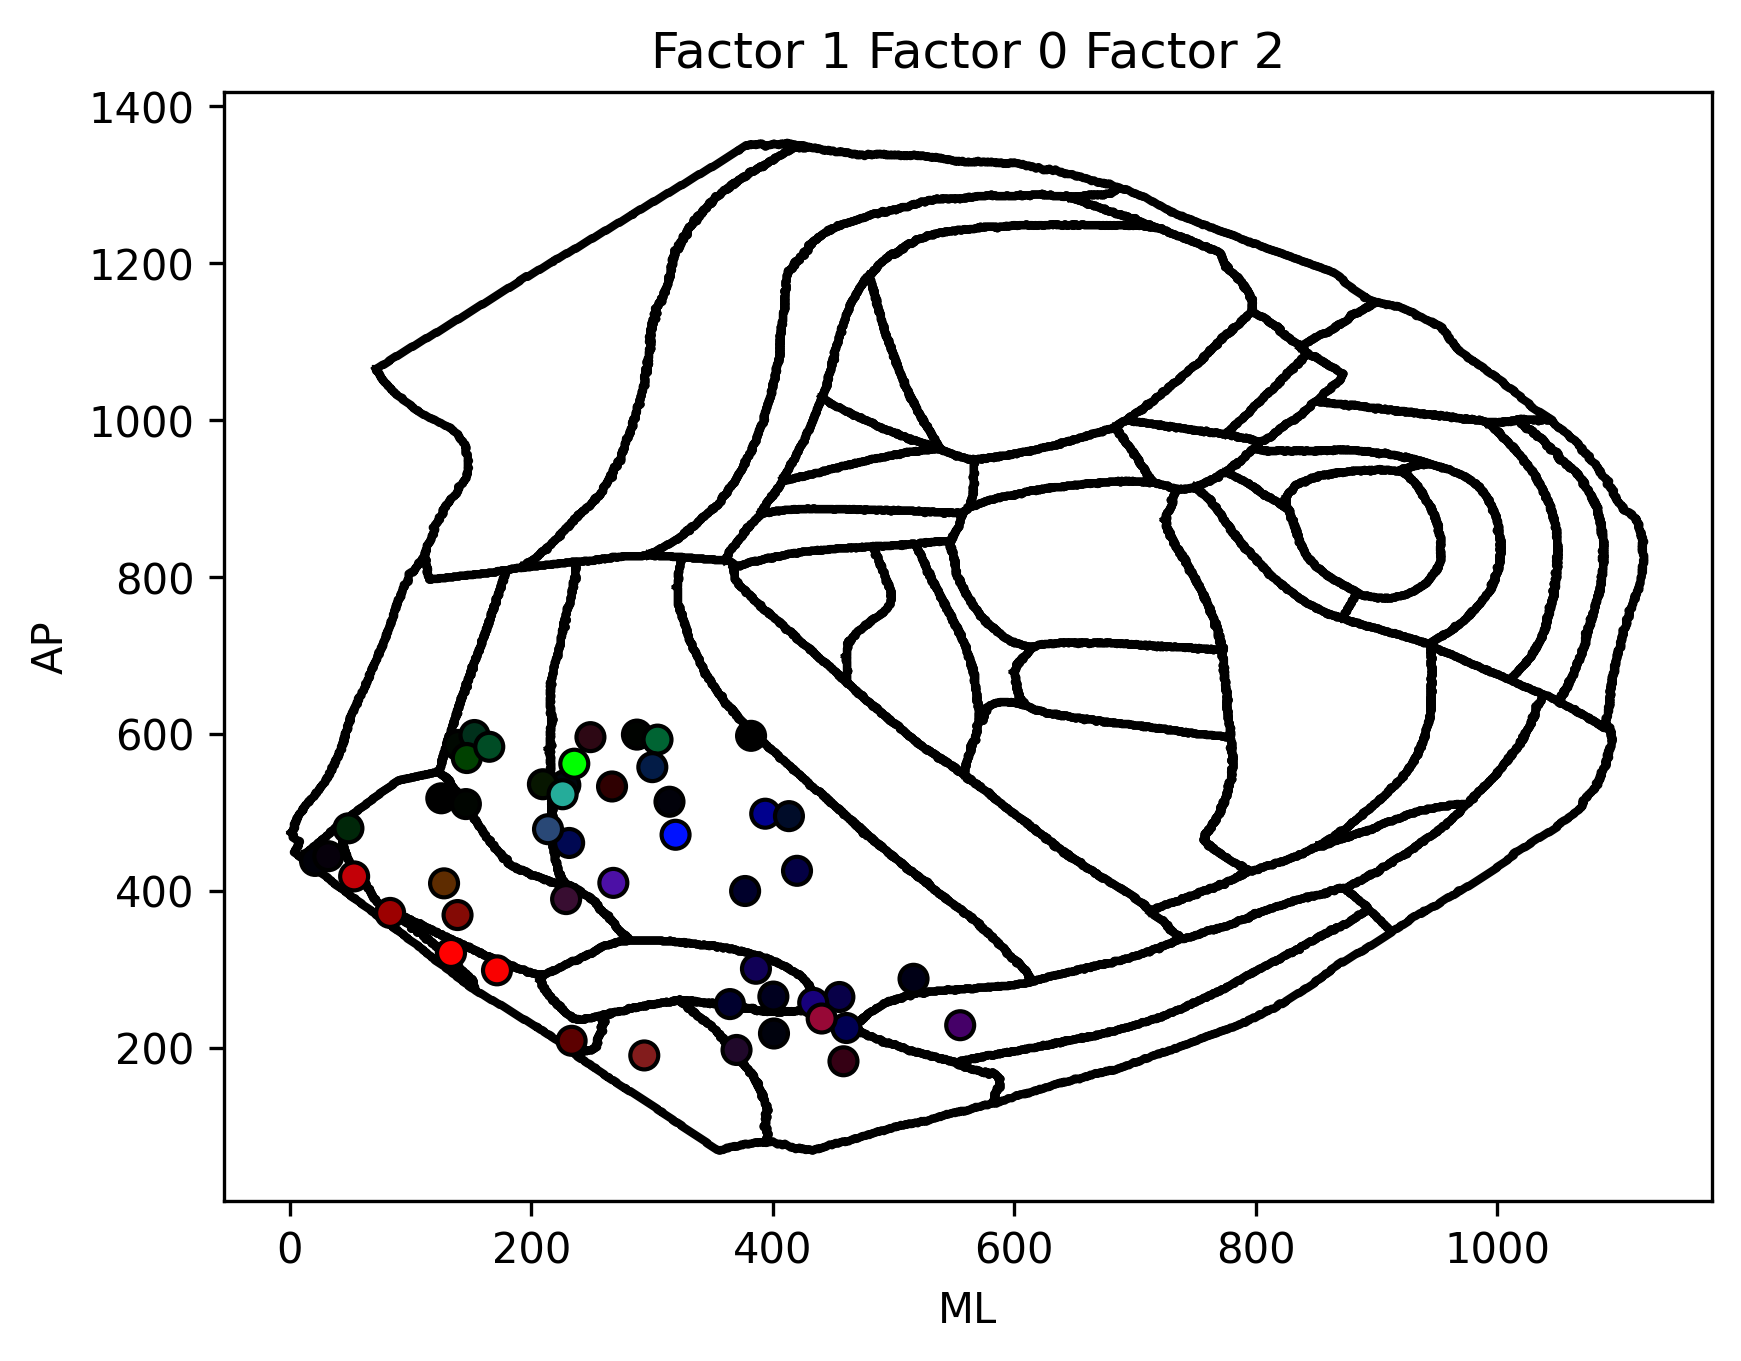

In [73]:

# rFactor = "Factor 0"
# gFactor = "Factor 1"
# bFactor = "Factor 2"

rFactor = "Factor 1"
gFactor = "Factor 0"
bFactor = "Factor 2"
plotData = ccfData.copy()
plt.figure(dpi=300)
for k, boundary_coords in bf_right_boundaries.items():
    plt.plot(*boundary_coords.T, color = 'k', lw= 2)

plotData['color'] = plotData.apply(lambda row: to_hex((row[rFactor], row[gFactor], row[bFactor])), axis=1)
palette = {color: color for color in plotData['color'].unique()}
plotData = plotData.sort_values(by='color',ascending=True) # sort for plotting largest value on top
ax = sns.scatterplot(plotData,x = "ML", y = "AP", s = 45, hue = "color",
                     edgecolor = 'black', linewidth = 1, zorder = 2, palette = palette)

ax.get_legend().remove()
plt.title(rFactor + " " + gFactor + " " + bFactor)
# plt.savefig("../results/joint factors flatmap.svg",dpi=300)

In [74]:
# Create RGB colors and convert them to hex
plotData['color'] = plotData.apply(lambda row: to_hex((row['Factor 0'], row['Factor 1'], row['Factor 2'])), axis=1)
# Create a color palette dictionary
palette = {color: color for color in plotData['color'].unique()}
# sns.scatterplot(data=X, x='posX', y='posY', hue='color', palette=X['color'].unique(), legend=False, s=100)

In [75]:
ccfData.sort_values("Factor 1", ascending=False).head(5)

,Channel,CCF Coord,Virus,Payload,ML,AP,DV,Capsid,CCF Struct,CCF Parent,Factor 0,Factor 1,Factor 2,Factor 3,Factor 4
Sample,,,,,,,,,,,,,,,
698035,488,"[100, 127, 236]",AAVrg-XFP,XFP,133.618581,320.676997,21.571068,AAVrg,ORBm2/3,ORBm,0.000000,1.000000,0.000000,0.204636,0.000000
698927,561,"[95, 117, 245]",RabV-XFP,XFP,171.660765,298.509909,51.351032,RabV,ORBm5,ORBm,0.000000,0.977963,0.000000,0.000000,0.123709
698035,561,"[133, 133, 232]",AAVrg-XFP,XFP,53.381823,418.263842,9.500000,AAVrg,ILA1,ILA,0.000000,0.765712,0.027195,0.173286,0.032192
689238,561,"[122, 138, 237]",AAVrg-XFP,XFP,83.157766,371.701000,22.596194,AAVrg,ILA5,ILA,0.000000,0.610028,0.000000,0.073956,0.046986
698927,488,"[104, 128, 295]",RabV-XFP,XFP,440.482395,237.094796,68.187895,RabV,MOs5,MOs,0.033137,0.591277,0.213579,0.000000,0.088075


In [76]:
lookFor = "698927 488"
for i, name in enumerate(expList):
    if name == lookFor:
        print(name)
        print(i)
        break

698927 488
33


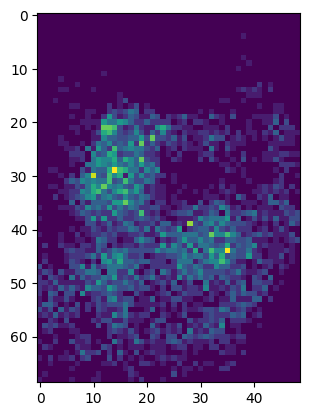

In [77]:
i = 33
plt.imshow(histArray[i,:].reshape((xLen,yLen)).T)

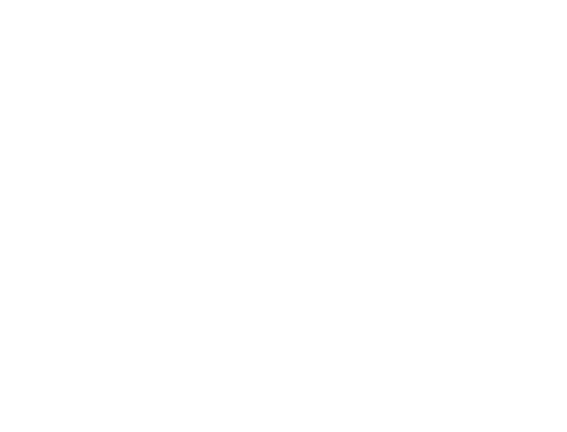

In [79]:
i = 4
showName = 2
field = "Factor " + str(i)
sns.stripplot(ccfData,x = "CCF Parent", y = field, color = "white", order=["ACAd","PL","ILA","FRP","ORBm","ORBl","ORBvl","MOs","AId"], s = 7, jitter = .2)
sns.despine()
plt.ylabel("Factor " + str(showName), color = "white")
plt.xlabel('Injection Site', color='white')
plt.axis('tight');

# Set the color of the axes to white
plt.gca().spines['bottom'].set_color('white')
plt.gca().spines['top'].set_color('white') 
plt.gca().spines['right'].set_color('white')
plt.gca().spines['left'].set_color('white')

# Set the color of the ticks to white
plt.tick_params(axis='x', colors='white')
plt.tick_params(axis='y', colors='white')


# Set the color of the axis labels to white
# plt.xlabel('X Axis', color='white')
# plt.ylabel('Y Axis', color='white')

plt.savefig("../results/input " + str(showName) + ".svg", dpi = 300, transparent=True)